### Welcome to go through our final project!
### We attempt to build a price recommendation system for new hosts at Airbnb. Price will be predicted based on the existing listings on Airbnb's platform.

# 1. Load packages and data

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import locale
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler as sc
from sklearn.model_selection import KFold
import re
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
#from google.colab import files
#uploaded = files.upload()

In [3]:
#Save the dataset as Pandas DataFrame
#import io

#df = pd.read_csv(io.BytesIO(uploaded['NewYor.csv']))

In [151]:
#code for our computers
# Remember to change the directory to where the file is located
df = pd.read_csv("New York.csv")

In [152]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,https://www.airbnb.com/rooms/2595,20190806030549,2019-08-07,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","- Spacious (500+ft²), immaculate and nicely fu...","Find your romantic getaway to this beautiful, ...",none,Centrally located in the heart of Manhattan ju...,NaN,Apartment is located on 37th Street between 5t...,"Guests have full access to the kitchen, bathro...",I am a Sound Therapy Practitioner and Kundalin...,"Make yourself at home, respect the space and t...",NaN,NaN,https://a0.muscache.com/im/pictures/f0813a11-4...,NaN,2845,https://www.airbnb.com/users/show/2845,Jennifer,2008-09-09,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,within a few hours,90%,NaN,f,https://a0.muscache.com/im/users/2845/profile_...,https://a0.muscache.com/im/users/2845/profile_...,Midtown,5.0,5.0,"['email', 'phone', 'reviews', 'kba', 'work_ema...",t,t,"New York, NY, United States",Midtown,Midtown,Manhattan,New York,NY,10018,New York,"New York, NY",US,United States,40.75362,-73.98377,f,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",NaN,$225.00,"$1,995.00",NaN,$350.00,$100.00,2,$0.00,1,1125,1,1,1125,1125,1.0,1125.0,a week ago,t,13,17,31,288,2019-08-07,46,12,2009-11-21,2019-07-14,95.0,10.0,9.0,10.0,10.0,10.0,9.0,f,NaN,NaN,f,f,strict_14_with_grace_period,t,t,2,1,0,1,0.39
1,3647,https://www.airbnb.com/rooms/3647,20190806030549,2019-08-06,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,none,NaN,NaN,NaN,NaN,NaN,Upon arrival please have a legibile copy of yo...,NaN,NaN,https://a0.muscache.com/im/pictures/838341/9b3...,NaN,4632,https://www.airbnb.com/users/show/4632,Elisabeth,2008-11-25,"New York, New York, United States",Make Up Artist National/ (Website hidden by Ai...,within a day,100%,NaN,f,https://a0.muscache.com/im/users/4632/profile_...,https://a0.muscache.com/im/users/4632/profile_...,Harlem,1.0,1.0,"['email', 'phone', 'google', 'reviews', 'jumio...",t,t,"New York, NY, United States",Harlem,Harlem,Manhattan,New York,NY,10027,New York,"New York, NY",US,United States,40.80902,-73.94190,t,Apartment,Private room,2,1.0,1.0,1.0,

In [153]:
# Here I strip the dollar sign of 'price' and transform it to numeric
locale.setlocale(locale.LC_ALL,'')
df['price']=df.price.map(lambda x: locale.atof(x.strip('$')))

In [154]:
# Do the same thing for "extre_people"
df['extra_people']=df.extra_people.map(lambda x: locale.atof(x.strip('$')))

In [155]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [156]:
print("The original dataset has {} rows and {} columns.".format(*df.shape))
print("It contains {} duplicates.".format(df.duplicated().sum()))

The original dataset has 48864 rows and 106 columns.
It contains 0 duplicates.


In [157]:
df.describe()

,id,scrape_id,thumbnail_url,medium_url,xl_picture_url,host_id,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,price,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,4.886400e+04,4.886400e+04,0.0,0.0,0.0,4.886400e+04,0.0,48846.000000,48846.000000,48864.000000,48864.000000,48864.000000,48808.000000,48837.000000,48822.000000,395.000000,48864.000000,48864.000000,48864.000000,48864.000000,4.886400e+04,48864.000000,48864.000000,4.886400e+04,4.886400e+04,48864.000000,4.886400e+04,48864.000000,48864.000000,48864.000000,48864.000000,48864.000000,48864.000000,37760.000000,37722.000000,37738.000000,37706.000000,37728.000000,37701.000000,37703.000000,48864.000000,48864.000000,48864.000000,48864.000000,38733.000000
mean,1.940851e+07,2.019081e+13,NaN,NaN,NaN,6.943161e+07,NaN,14.832269,14.832269,40.728664,-73.951850,2.846206,1.144187,1.173455,1.548073,703.607595,151.453176,1.516515,14.375900,7.093116,4.541429e+04,6.859590,17.471554,4.540361e+04,4.541405e+04,11.744106,4.540761e+04,6.953483,15.471943,25.921742,112.483505,23.392191,9.149865,93.930508,9.620248,9.278181,9.748820,9.755831,9.567492,9.398748,7.438278,5.788044,1.538740,0.111493,1.365694
std,1.124290e+07,1.306263e+01,NaN,NaN,NaN,8.058217e+07,NaN,88.245394,88.245394,0.054794,0.046440,1.882121,0.431976,0.746215,1.112344,529.954366,236.585525,1.143319,24.510693,20.264170,9.715671e+06,20.148813,156.030984,9.715671e+06,9.715671e+06,76.730659,9.715671e+06,9.699449,20.061996,31.495750,132.373994,44.939690,16.064845,8.630940,0.846619,1.084325,0.719149,0.731741,0.762230,0.912826,34.949053,34.006697,6.439867,0.993281,1.692891
min,2.595000e+03,2.019081e+13,NaN,NaN,NaN,2.438000e+03,NaN,0.000000,0.000000,40.499790,-74.244420,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,9.577635e+06,2.019081e+13,NaN,NaN,NaN,8.048590e+06,NaN,1.000000,1.000000,40.689797,-73.982952,2.000000,1.000000,1.000000,1.000000,336.500000,69.000000,1.000000,0.000000,1.000000,2.900000e+01,1.000000,2.000000,2.800000e+01,2.800000e+01,1.300000,2.800000e+01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,92.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.190000
50%,1.994839e+07,2.019081e+13,NaN,NaN,NaN,3.168654e+07,NaN,1.000000,1.000000,40.722880,-73.955510,2.000000,1.000000,1.000000,1.000000,700.000000,105.000000,1.000000,0.000000,2.000000,1.124000e+03,2.000000,3.000000,3.660000e+02,9.990000e+02,2.900000,7.300000e+02,1.000000,5.000000,9.000000,41.000000,5.000000,2.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,1.000000,0.000000,0.710000
75%,2.974014e+07,2.019081e+13,NaN,NaN,NaN,1.096553e+08,NaN,2.000000,2.000000,40.762970,-73.935628,4.000000,1.000000,1.000000,2.000000,950.000000,175.000000,2.000000,25.000000,5.000000,1.125000e+03,5.000000,5.000000,1.125000e+03,1.125000e+03,5.000000,1.125000e+03,11.000000,28.000000,50.000000,232.000000,24.000000,11.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,1.000000,1.000000,0.000000,2.000000
max,3

In [158]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,https://www.airbnb.com/rooms/2595,20190806030549,2019-08-07,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","- Spacious (500+ft²), immaculate and nicely fu...","Find your romantic getaway to this beautiful, ...",none,Centrally located in the heart of Manhattan ju...,NaN,Apartment is located on 37th Street between 5t...,"Guests have full access to the kitchen, bathro...",I am a Sound Therapy Practitioner and Kundalin...,"Make yourself at home, respect the space and t...",NaN,NaN,https://a0.muscache.com/im/pictures/f0813a11-4...,NaN,2845,https://www.airbnb.com/users/show/2845,Jennifer,2008-09-09,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,within a few hours,90%,NaN,f,https://a0.muscache.com/im/users/2845/profile_...,https://a0.muscache.com/im/users/2845/profile_...,Midtown,5.0,5.0,"['email', 'phone', 'reviews', 'kba', 'work_ema...",t,t,"New York, NY, United States",Midtown,Midtown,Manhattan,New York,NY,10018,New York,"New York, NY",US,United States,40.75362,-73.98377,f,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",NaN,225.0,"$1,995.00",NaN,$350.00,$100.00,2,0.0,1,1125,1,1,1125,1125,1.0,1125.0,a week ago,t,13,17,31,288,2019-08-07,46,12,2009-11-21,2019-07-14,95.0,10.0,9.0,10.0,10.0,10.0,9.0,f,NaN,NaN,f,f,strict_14_with_grace_period,t,t,2,1,0,1,0.39
1,3647,https://www.airbnb.com/rooms/3647,20190806030549,2019-08-06,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,none,NaN,NaN,NaN,NaN,NaN,Upon arrival please have a legibile copy of yo...,NaN,NaN,https://a0.muscache.com/im/pictures/838341/9b3...,NaN,4632,https://www.airbnb.com/users/show/4632,Elisabeth,2008-11-25,"New York, New York, United States",Make Up Artist National/ (Website hidden by Ai...,within a day,100%,NaN,f,https://a0.muscache.com/im/users/4632/profile_...,https://a0.muscache.com/im/users/4632/profile_...,Harlem,1.0,1.0,"['email', 'phone', 'google', 'reviews', 'jumio...",t,t,"New York, NY, United States",Harlem,Harlem,Manhattan,New York,NY,10027,New York,"New York, NY",US,United States,40.80902,-73.94190,t,Apartment,Private room,2,1.0,1.0,1.0,Pull

In [159]:
# Check for the distribution of price, we do have some extreme values!
df.price.describe()

count    48864.000000
mean       151.453176
std        236.585525
min          0.000000
25%         69.000000
50%        105.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

In [160]:
# Check the columns we currently have
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)

# 2. Data Preparation

## 2.1 Choose the features to begin with

In [161]:
# Here we set as many features as possible to be our initial features. 
# We can add on new features here to test out.
initial_features = ['id',  'host_has_profile_pic', 'host_identity_verified','neighbourhood_group_cleansed', 
                    "longitude","latitude",'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms','beds', 'bed_type', 'amenities', 'square_feet',  'minimum_nights',  'maximum_nights',
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
                    "price"]

In [162]:
df_raw = df[initial_features]

In [163]:
print("The dataset has {} rows and {} columns - with initial feature selections.".format(*df_raw.shape))

The dataset has 48864 rows and 21 columns - with initial feature selections.


In [164]:
# Check for room types
df_raw.room_type.value_counts(normalize=True)

Entire home/apt    0.517682
Private room       0.458354
Shared room        0.023964
Name: room_type, dtype: float64

In [165]:
# Check for property types
df_raw.property_type.value_counts(normalize=True)

Apartment                 0.790050
House                     0.078708
Townhouse                 0.033951
Condominium               0.030595
Loft                      0.028897
Serviced apartment        0.010335
Guest suite               0.007429
Hotel                     0.004646
Boutique hotel            0.003888
Other                     0.002415
Bed and breakfast         0.001801
Resort                    0.001473
Hostel                    0.001269
Guesthouse                0.001146
Bungalow                  0.000778
Villa                     0.000573
Tiny house                0.000389
Aparthotel                0.000348
Boat                      0.000266
Camper/RV                 0.000205
Cottage                   0.000143
Tent                      0.000123
Earth house               0.000082
Cabin                     0.000061
Houseboat                 0.000061
Casa particular (Cuba)    0.000041
Farm stay                 0.000041
Bus                       0.000041
Yurt                

## 2.2 Filter the target variable

In [166]:
df_raw['price'].describe()

count    48864.000000
mean       151.453176
std        236.585525
min          0.000000
25%         69.000000
50%        105.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

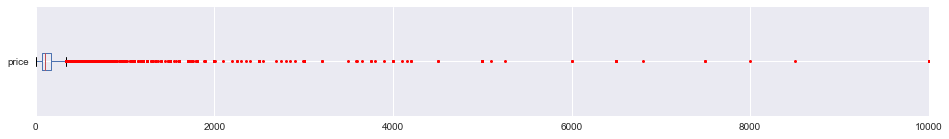

In [167]:
# Visualize price using box plot. We can do other visualization too.
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df_raw['price'].plot(kind='box', xlim=(0, 10000), vert=False, flierprops=red_square, figsize=(16,2));

In [168]:
# Set the threshold to be three standard deviations from mean of price
threshold=df_raw.loc[:,"price"].mean()+3*df_raw.loc[:,"price"].std()
print(threshold)

861.2097497205757


In [169]:
# Drop records that have price >threshold and price=0
df_raw.drop(df_raw[ (df_raw.price > threshold) | (df_raw.price == 0) ].index, axis=0, inplace=True)
df_raw['price'].describe()

count    48480.000000
mean       138.006663
std        106.014177
min         10.000000
25%         69.000000
50%        105.000000
75%        175.000000
max        860.000000
Name: price, dtype: float64

In [170]:
print("The dataset has {} rows and {} columns - after being price-wise preprocessed.".format(*df_raw.shape))

The dataset has 48480 rows and 21 columns - after being price-wise preprocessed.


## 2.3 Clean the missing values

In [171]:
# Check Missing Values
df_raw.isna().sum()

id                                  0
host_has_profile_pic               18
host_identity_verified             18
neighbourhood_group_cleansed        0
longitude                           0
latitude                            0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                          54
bedrooms                           27
beds                               40
bed_type                            0
amenities                           0
square_feet                     48088
minimum_nights                      0
maximum_nights                      0
instant_bookable                    0
is_business_travel_ready            0
cancellation_policy                 1
price                               0
dtype: int64

In [172]:
# drop columns with too many Nan's
df_raw.drop(columns=['square_feet'], inplace=True)
# drop rows with NaN's in bathrooms and bedrooms and beds and cancellation policy
df_raw.dropna(subset=['bathrooms', 'bedrooms', 'cancellation_policy','beds',], inplace=True)

In [173]:
# replace host_has_profile_pic and host_identity_verified Nan's with no
df_raw.host_has_profile_pic.fillna(value='f', inplace=True)
df_raw.host_has_profile_pic.unique()

df_raw.host_identity_verified.fillna(value='f', inplace=True)
df_raw.host_identity_verified.unique()

array(['t', 'f'], dtype=object)

In [174]:
# Check again
df_raw.isna().sum()

id                              0
host_has_profile_pic            0
host_identity_verified          0
neighbourhood_group_cleansed    0
longitude                       0
latitude                        0
property_type                   0
room_type                       0
accommodates                    0
bathrooms                       0
bedrooms                        0
beds                            0
bed_type                        0
amenities                       0
minimum_nights                  0
maximum_nights                  0
instant_bookable                0
is_business_travel_ready        0
cancellation_policy             0
price                           0
dtype: int64

In [175]:
print("The dataset has {} rows and {} columns - after having dealt with missing values.".format(*df_raw.shape))

The dataset has 48376 rows and 20 columns - after having dealt with missing values.


## 2.4 Feature Engineering

### 2.4.1 Distance to the center of New York

In [176]:
# Distance to the Center of New York

from geopy.distance import great_circle
def distance_to_mid(lat, lon):
    # I got the center location of Manhattan, probably the most expensive.
    ny_centre = (40.7831, -73.9712)
    accommodation = (lat, lon)
    return great_circle(ny_centre, accommodation).km

df_raw['distance'] = df_raw.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)

### 2.4.2 Amenities

In [177]:
from collections import Counter
results = Counter()
df['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results.update)

results

Counter({'TV': 33057,
         'Wifi': 47647,
         'Air conditioning': 41803,
         'Kitchen': 44666,
         'Paid parking off premises': 4671,
         'Free street parking': 14845,
         'Indoor fireplace': 1942,
         'Heating': 45519,
         'Family/kid friendly': 13283,
         'Smoke detector': 42346,
         'Carbon monoxide detector': 33840,
         'Fire extinguisher': 18574,
         'Essentials': 45049,
         'Shampoo': 33013,
         'Lock on bedroom door': 18266,
         'Hangers': 36147,
         'Hair dryer': 32096,
         'Iron': 30059,
         'Laptop friendly workspace': 30928,
         'Self check-in': 11320,
         'Keypad': 2414,
         'Private living room': 6351,
         'Bathtub': 4179,
         'Hot water': 24542,
         'Bed linens': 14333,
         'Extra pillows and blankets': 9769,
         'Ethernet connection': 1838,
         'Coffee maker': 12084,
         'Refrigerator': 16058,
         'Dishes and silverware': 14366,


In [178]:
# Convert all the amenities into their own columns and boolean
df=df_raw
for pair in results.most_common(130):
  amenity=str(pair[0])
  df[amenity]=df['amenities'].str.contains(amenity)

df.head()

,id,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,longitude,latitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,minimum_nights,maximum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,price,distance,Wifi,Heating,Essentials,Kitchen,Smoke detector,Air conditioning,Hangers,Carbon monoxide detector,TV,Shampoo,Hair dryer,Laptop friendly workspace,Iron,Hot water,Washer,Dryer,Fire extinguisher,Lock on bedroom door,First aid kit,Refrigerator,Internet,Free street parking,Dishes and silverware,Bed linens,Stove,Oven,Elevator,Microwave,Cooking basics,Family/kid friendly,Coffee maker,Cable TV,Self check-in,Buzzer/wireless intercom,No stairs or steps to enter,Extra pillows and blankets,Long term stays allowed,Private entrance,translation missing: en.hosting_amenity_50,Host greets you,Luggage dropoff allowed,translation missing: en.hosting_amenity_49,Dishwasher,Pets allowed,Lockbox,Private living room,24-hour check-in,Paid parking off premises,Gym,Safety card,Bathtub,Breakfast,Other,Well-lit path to entrance,Patio or balcony,Pets live on this property,Free parking on premises,Garden or backyard,Smoking allowed,Keypad,Wide hallways,Wide entrance for guests,Doorman,Extra space around bed,Indoor fireplace,BBQ grill,Room-darkening shades,Ethernet connection,Wide entrance,Accessible-height bed,Wheelchair accessible,Wide entryway,Hot tub,Building staff,Single level home,Cleaning before checkout,Flat path to guest entrance,Suitable for events,Children’s books and toys,Pack ’n Play/travel crib,Accessible-height toilet,Paid parking on premises,Cat(s),Window guards,Dog(s),High chair,Wide doorway to guest bathroom,Crib,Smart lock,Handheld shower head,toilet,Wide clearance to shower,Pool,Babysitter recommendations,Children’s dinnerware,Pocket wifi,Outlet covers,Game console,Waterfront,Baby bath,Fixed grab bars for shower,Stair gates,Changing table,Beach essentials,Roll-in shower,,Fixed grab bars for toilet,Baby monitor,EV charger,Fireplace guards,Beachfront,Disabled parking spot,Other pet(s),Table corner guards,Bathtub with bath chair,Lake access,Shower chair,Hot water kettle,Firm mattress,Full kitchen,Electric profiling bed,Ski-in/Ski-out,Private bathroom,Washer / Dryer,Ground floor access,Mobile hoist,Air purifier,Pool with pool hoist,Kitchenette,Ceiling hoist
0,2595,t,t,Manhattan,-73.98377,40.75362,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Paid park...",1,1125,f,f,strict_14_with_grace_period,225.0,3.444715,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,True,True,False,True,False,True,True,True,True,True,False,False,True,True,True,False,True,False,True,True,True,False,False,False,True,False,False,False,False,True,False,True,False,False,True,False,False,True,False,False,False,False,False,True,False,True,False,False,True,False,False,True,True,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,3647,t,t,Manhattan,-73.94190,40.80902,Apartment,Private room,2,1.0,1.0,1.0,Pull-out Sofa,"{""Cable TV"",Internet,Wifi,""Air conditioning"",K...",3,7,f,f,strict_14_with_grace_period,150.0,3.793456,True,True,False,True,True,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [179]:
# create a new dataframe for common 30
Top30_dff = pd.DataFrame(results.most_common(30), columns=['amenity', 'count'])
Top30_amen = Top30_dff['amenity'].values

Top30_df = df[Top30_amen].astype(int)
Top30_df.head()

,Wifi,Heating,Essentials,Kitchen,Smoke detector,Air conditioning,Hangers,Carbon monoxide detector,TV,Shampoo,Hair dryer,Laptop friendly workspace,Iron,Hot water,Washer,Dryer,Fire extinguisher,Lock on bedroom door,First aid kit,Refrigerator,Internet,Free street parking,Dishes and silverware,Bed linens,Stove,Oven,Elevator,Microwave,Cooking basics,Family/kid friendly
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,1,0,1,1,1,1,1,0,0,1,1
1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,1
4,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0
6,1,1,1,0,1,1,1,0,1,1,1,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1


In [180]:
# create a new dataframe for common 20
Top20_dff = pd.DataFrame(results.most_common(20), columns=['amenity', 'count'])
Top20_amen = Top20_dff['amenity'].values

Top20_df = df[Top20_amen].astype(int)
Top20_df.head()

,Wifi,Heating,Essentials,Kitchen,Smoke detector,Air conditioning,Hangers,Carbon monoxide detector,TV,Shampoo,Hair dryer,Laptop friendly workspace,Iron,Hot water,Washer,Dryer,Fire extinguisher,Lock on bedroom door,First aid kit,Refrigerator
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,1
1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,0
4,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,0,1,0,0,0
6,1,1,1,0,1,1,1,0,1,1,1,0,1,0,0,0,0,1,0,1


In [181]:
# create a new dataframe for common 10
Top10_dff = pd.DataFrame(results.most_common(10), columns=['amenity', 'count'])
Top10_amen = Top10_dff['amenity'].values

Top10_df = df[Top10_amen].astype(int)
Top10_df.head()

,Wifi,Heating,Essentials,Kitchen,Smoke detector,Air conditioning,Hangers,Carbon monoxide detector,TV,Shampoo
0,1,1,1,1,1,1,1,1,1,1
1,1,1,0,1,1,1,0,1,1,0
2,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,0,1,1,1,1
6,1,1,1,0,1,1,1,0,1,1


In [182]:
df.drop(['amenities'], axis=1, inplace=True)

Some extra cleaning are needed.

In [183]:
df.info()
# Let's drop id too.
df.drop(['id'], axis=1, inplace=True)
# Since we already have distance.
df.drop(['latitude', 'longitude'], axis=1, inplace=True)

# Let's encode all categorical features into dummy variables.
for col in ['host_has_profile_pic','host_identity_verified', 'neighbourhood_group_cleansed',
           'property_type', 'room_type', 'bed_type', 'instant_bookable', 
            'is_business_travel_ready', 'cancellation_policy']:
    df[col] = df[col].astype('category')
# Recode Categorical features to binary variables
num_feats = df.select_dtypes(include=['float64', 'int64', 'bool']).copy()

# one-hot encoding of categorical features
cat_feats = df.select_dtypes(include=['category']).copy()
cat_feats = pd.get_dummies(cat_feats)
df = pd.concat([num_feats, cat_feats], axis=1)

print(df.shape)
df.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48376 entries, 0 to 48863
Columns: 150 entries, id to Ceiling hoist
dtypes: bool(130), float64(7), int64(4), object(9)
memory usage: 13.7+ MB
(48376, 201)


,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,price,distance,Wifi,Heating,Essentials,Kitchen,Smoke detector,Air conditioning,Hangers,Carbon monoxide detector,TV,Shampoo,Hair dryer,Laptop friendly workspace,Iron,Hot water,Washer,Dryer,Fire extinguisher,Lock on bedroom door,First aid kit,Refrigerator,Internet,Free street parking,Dishes and silverware,Bed linens,Stove,Oven,Elevator,Microwave,Cooking basics,Family/kid friendly,Coffee maker,Cable TV,Self check-in,Buzzer/wireless intercom,No stairs or steps to enter,Extra pillows and blankets,Long term stays allowed,Private entrance,translation missing: en.hosting_amenity_50,Host greets you,Luggage dropoff allowed,translation missing: en.hosting_amenity_49,Dishwasher,Pets allowed,Lockbox,Private living room,24-hour check-in,Paid parking off premises,Gym,Safety card,Bathtub,Breakfast,Other,Well-lit path to entrance,Patio or balcony,Pets live on this property,Free parking on premises,Garden or backyard,Smoking allowed,Keypad,Wide hallways,Wide entrance for guests,Doorman,Extra space around bed,Indoor fireplace,BBQ grill,Room-darkening shades,Ethernet connection,Wide entrance,Accessible-height bed,Wheelchair accessible,Wide entryway,Hot tub,Building staff,Single level home,Cleaning before checkout,Flat path to guest entrance,Suitable for events,Children’s books and toys,Pack ’n Play/travel crib,Accessible-height toilet,Paid parking on premises,Cat(s),Window guards,Dog(s),High chair,Wide doorway to guest bathroom,Crib,Smart lock,Handheld shower head,toilet,Wide clearance to shower,Pool,Babysitter recommendations,Children’s dinnerware,Pocket wifi,Outlet covers,Game console,Waterfront,Baby bath,Fixed grab bars for shower,Stair gates,Changing table,Beach essentials,Roll-in shower,,Fixed grab bars for toilet,Baby monitor,EV charger,Fireplace guards,Beachfront,Disabled parking spot,Other pet(s),Table corner guards,Bathtub with bath chair,Lake access,Shower chair,Hot water kettle,Firm mattress,Full kitchen,Electric profiling bed,Ski-in/Ski-out,Private bathroom,Washer / Dryer,Ground floor access,Mobile hoist,Air purifier,Pool with pool hoist,Kitchenette,Ceiling hoist,host_has_profile_pic_f,host_has_profile_pic_t,host_identity_verified_f,host_identity_verified_t,neighbourhood_group_cleansed_Bronx,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island,property_type_Aparthotel,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Bus,property_type_Cabin,property_type_Camper/RV,property_type_Casa particular (Cuba),property_type_Castle,property_type_Cave,property_type_Condominium,property_type_Cottage,property_type_Dome house,property_type_Earth house,property_type_Farm stay,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Houseboat,property_type_Lighthouse,property_type_Loft,property_type_Nature lodge,property_type_Other,property_type_Resort,property_type_Serviced apartment,property_type_Tent,property_type_Timeshare,property_type_Tiny house,property_type_Townhouse,property_type_Treehouse,property_type_Villa,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_f,instant_bookable_t,is_business_travel_ready_f,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
0,2,1.0,0.0,1.0,1,1125,225.0,3.444715,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,True,True,False,True,False,True,True,True,True,True,False,False,True,True,True,False,True,False,True,True,True,False,False,False,True,Fa

In [184]:
#Changing amenities in main df to binary
df.iloc[:, 8:138] = df.iloc[:, 8:138].astype(int)
df.iloc[:, 8:138].head(2)

,Wifi,Heating,Essentials,Kitchen,Smoke detector,Air conditioning,Hangers,Carbon monoxide detector,TV,Shampoo,Hair dryer,Laptop friendly workspace,Iron,Hot water,Washer,Dryer,Fire extinguisher,Lock on bedroom door,First aid kit,Refrigerator,Internet,Free street parking,Dishes and silverware,Bed linens,Stove,Oven,Elevator,Microwave,Cooking basics,Family/kid friendly,Coffee maker,Cable TV,Self check-in,Buzzer/wireless intercom,No stairs or steps to enter,Extra pillows and blankets,Long term stays allowed,Private entrance,translation missing: en.hosting_amenity_50,Host greets you,Luggage dropoff allowed,translation missing: en.hosting_amenity_49,Dishwasher,Pets allowed,Lockbox,Private living room,24-hour check-in,Paid parking off premises,Gym,Safety card,Bathtub,Breakfast,Other,Well-lit path to entrance,Patio or balcony,Pets live on this property,Free parking on premises,Garden or backyard,Smoking allowed,Keypad,Wide hallways,Wide entrance for guests,Doorman,Extra space around bed,Indoor fireplace,BBQ grill,Room-darkening shades,Ethernet connection,Wide entrance,Accessible-height bed,Wheelchair accessible,Wide entryway,Hot tub,Building staff,Single level home,Cleaning before checkout,Flat path to guest entrance,Suitable for events,Children’s books and toys,Pack ’n Play/travel crib,Accessible-height toilet,Paid parking on premises,Cat(s),Window guards,Dog(s),High chair,Wide doorway to guest bathroom,Crib,Smart lock,Handheld shower head,toilet,Wide clearance to shower,Pool,Babysitter recommendations,Children’s dinnerware,Pocket wifi,Outlet covers,Game console,Waterfront,Baby bath,Fixed grab bars for shower,Stair gates,Changing table,Beach essentials,Roll-in shower,,Fixed grab bars for toilet,Baby monitor,EV charger,Fireplace guards,Beachfront,Disabled parking spot,Other pet(s),Table corner guards,Bathtub with bath chair,Lake access,Shower chair,Hot water kettle,Firm mattress,Full kitchen,Electric profiling bed,Ski-in/Ski-out,Private bathroom,Washer / Dryer,Ground floor access,Mobile hoist,Air purifier,Pool with pool hoist,Kitchenette,Ceiling hoist
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,1,0,1,1,1,1,1,0,0,1,1,1,0,1,0,1,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [185]:
#Feature Engineering
#Common amenities - cor 0.289
df['Common_amenities'] = df.Heating * df.Wifi * df.TV * df.Washer * df.Kitchen * \
df['Air conditioning']
np.corrcoef(df['Common_amenities'], df['price'])

#sum(df['Common_amenities'])

array([[1.        , 0.28922543],
       [0.28922543, 1.        ]])

In [186]:
#Family friendly - cor 0.290
df['Fam_friendly'] = df['Family/kid friendly'] + df['Crib'] + df['High chair'] + \
df['Pack ’n Play/travel crib'] + df['Iron'] + df['Shampoo'] + df['Pool'] + df['Washer'] 
np.corrcoef(df['Fam_friendly'], df['price'])

array([[1.        , 0.29035291],
       [0.29035291, 1.        ]])

In [187]:
#Luxury Features - cor .229
df['Luxury'] = df['Hot tub'] + df['Pool'] + df['Gym'] + df['Indoor fireplace'] + \
df['Bathtub']
np.corrcoef(df['Luxury'], df['price'])

array([[1.        , 0.22978646],
       [0.22978646, 1.        ]])

In [188]:
#Safety and Convenience Features - cor .208
df['Safety'] = df['Private entrance'] + df['Doorman'] + df['Building staff'] 
np.corrcoef(df['Safety'], df['price'])

array([[1.        , 0.20810769],
       [0.20810769, 1.        ]])

In [189]:
#Unwanted Features  - cor -.176
df['Unwanted'] = df['Free street parking'] + df['Pets live on this property'] + \
df['Lock on bedroom door'] + df['Smoking allowed'] + df['Cleaning before checkout']
np.corrcoef(df['Unwanted'], df['price'])

array([[ 1.        , -0.17638896],
       [-0.17638896,  1.        ]])

In [190]:
#Sum of all amenities - cor 0.17
df_amen = df.iloc[:, 8:138]
df['Amenities_sum'] = df_amen.sum(axis = 1)
np.corrcoef(df['Amenities_sum'], df['price'])

array([[1.       , 0.1716249],
       [0.1716249, 1.       ]])

In [191]:
#Sum of top 30 most common amenities - cor 0.17
df['Amenities30_sum'] = Top30_df.sum(axis = 1)
np.corrcoef(df['Amenities30_sum'], df['price'])

array([[1.        , 0.17020747],
       [0.17020747, 1.        ]])

In [192]:
#Sum of top 20 most common amenities - cor 0.18
df['Amenities20_sum'] = Top20_df.sum(axis = 1)
np.corrcoef(df['Amenities20_sum'], df['price'])

array([[1.        , 0.18193846],
       [0.18193846, 1.        ]])

In [193]:
#Sum of top 10 most common amenities - cor 0.197
df['Amenities10_sum'] = Top10_df.sum(axis = 1)
np.corrcoef(df['Amenities10_sum'], df['price'])

array([[1.        , 0.19725766],
       [0.19725766, 1.        ]])

In [194]:
#Not Manhattan  - cor -.30 -> this might also be captured in distance from Manhattan
df['Not_Manhattan'] = df['neighbourhood_group_cleansed_Brooklyn'] + \
df['neighbourhood_group_cleansed_Queens'] + df['neighbourhood_group_cleansed_Bronx'] + \
df['neighbourhood_group_cleansed_Staten Island']

np.corrcoef(df['Not_Manhattan'], df['price'])

array([[ 1.        , -0.30109761],
       [-0.30109761,  1.        ]])

### 2.4.3 Rooms

In [195]:
# Find the correlation between AccomperBed and the price
df['TotalRooms'] = df['bathrooms'] + df['bedrooms']

import numpy.ma as ma
print(ma.corrcoef(ma.masked_invalid(df['TotalRooms']),ma.masked_invalid(df['price'])))

[[1.0 0.40314488730446146]
 [0.40314488730446146 1.0]]


### 2.4.4 Decription Text Analysis

In [196]:
# A new dataframe for dipeeka to try text analysis.
# You need to install nltk in Anaconda Prompt
import nltk
#nltk.download('punkt')
df_text= pd.read_csv("New York.csv")
df_text['text']=df_text['description']
df_text[['text']].fillna(value='', inplace=True)

#if not necessary all lower
a = df_text['text'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)
print (word_dist)

rslt = pd.DataFrame(word_dist.most_common(1000),
                    columns=['Word', 'Frequency'])
print(rslt)

<FreqDist with 68127 samples and 7532312 outcomes>
                Word  Frequency
0                  ,     421467
1                  .     368726
2                the     288170
3                and     263961
4                  a     189954
5                 to     164536
6                 is     128326
7                 in     126939
8                 of     104744
9               with      93766
10               you      81352
11         apartment      66797
12               for      59233
13              room      55036
14              from      49745
15                 !      48821
16                 )      44456
17                 (      41975
18               are      39196
19           kitchen      38005
20           bedroom      37628
21                on      37619
22              this      35759
23                 i      35601
24                it      32636
25              will      31356
26              have      31055
27                 -      30218
28              your 

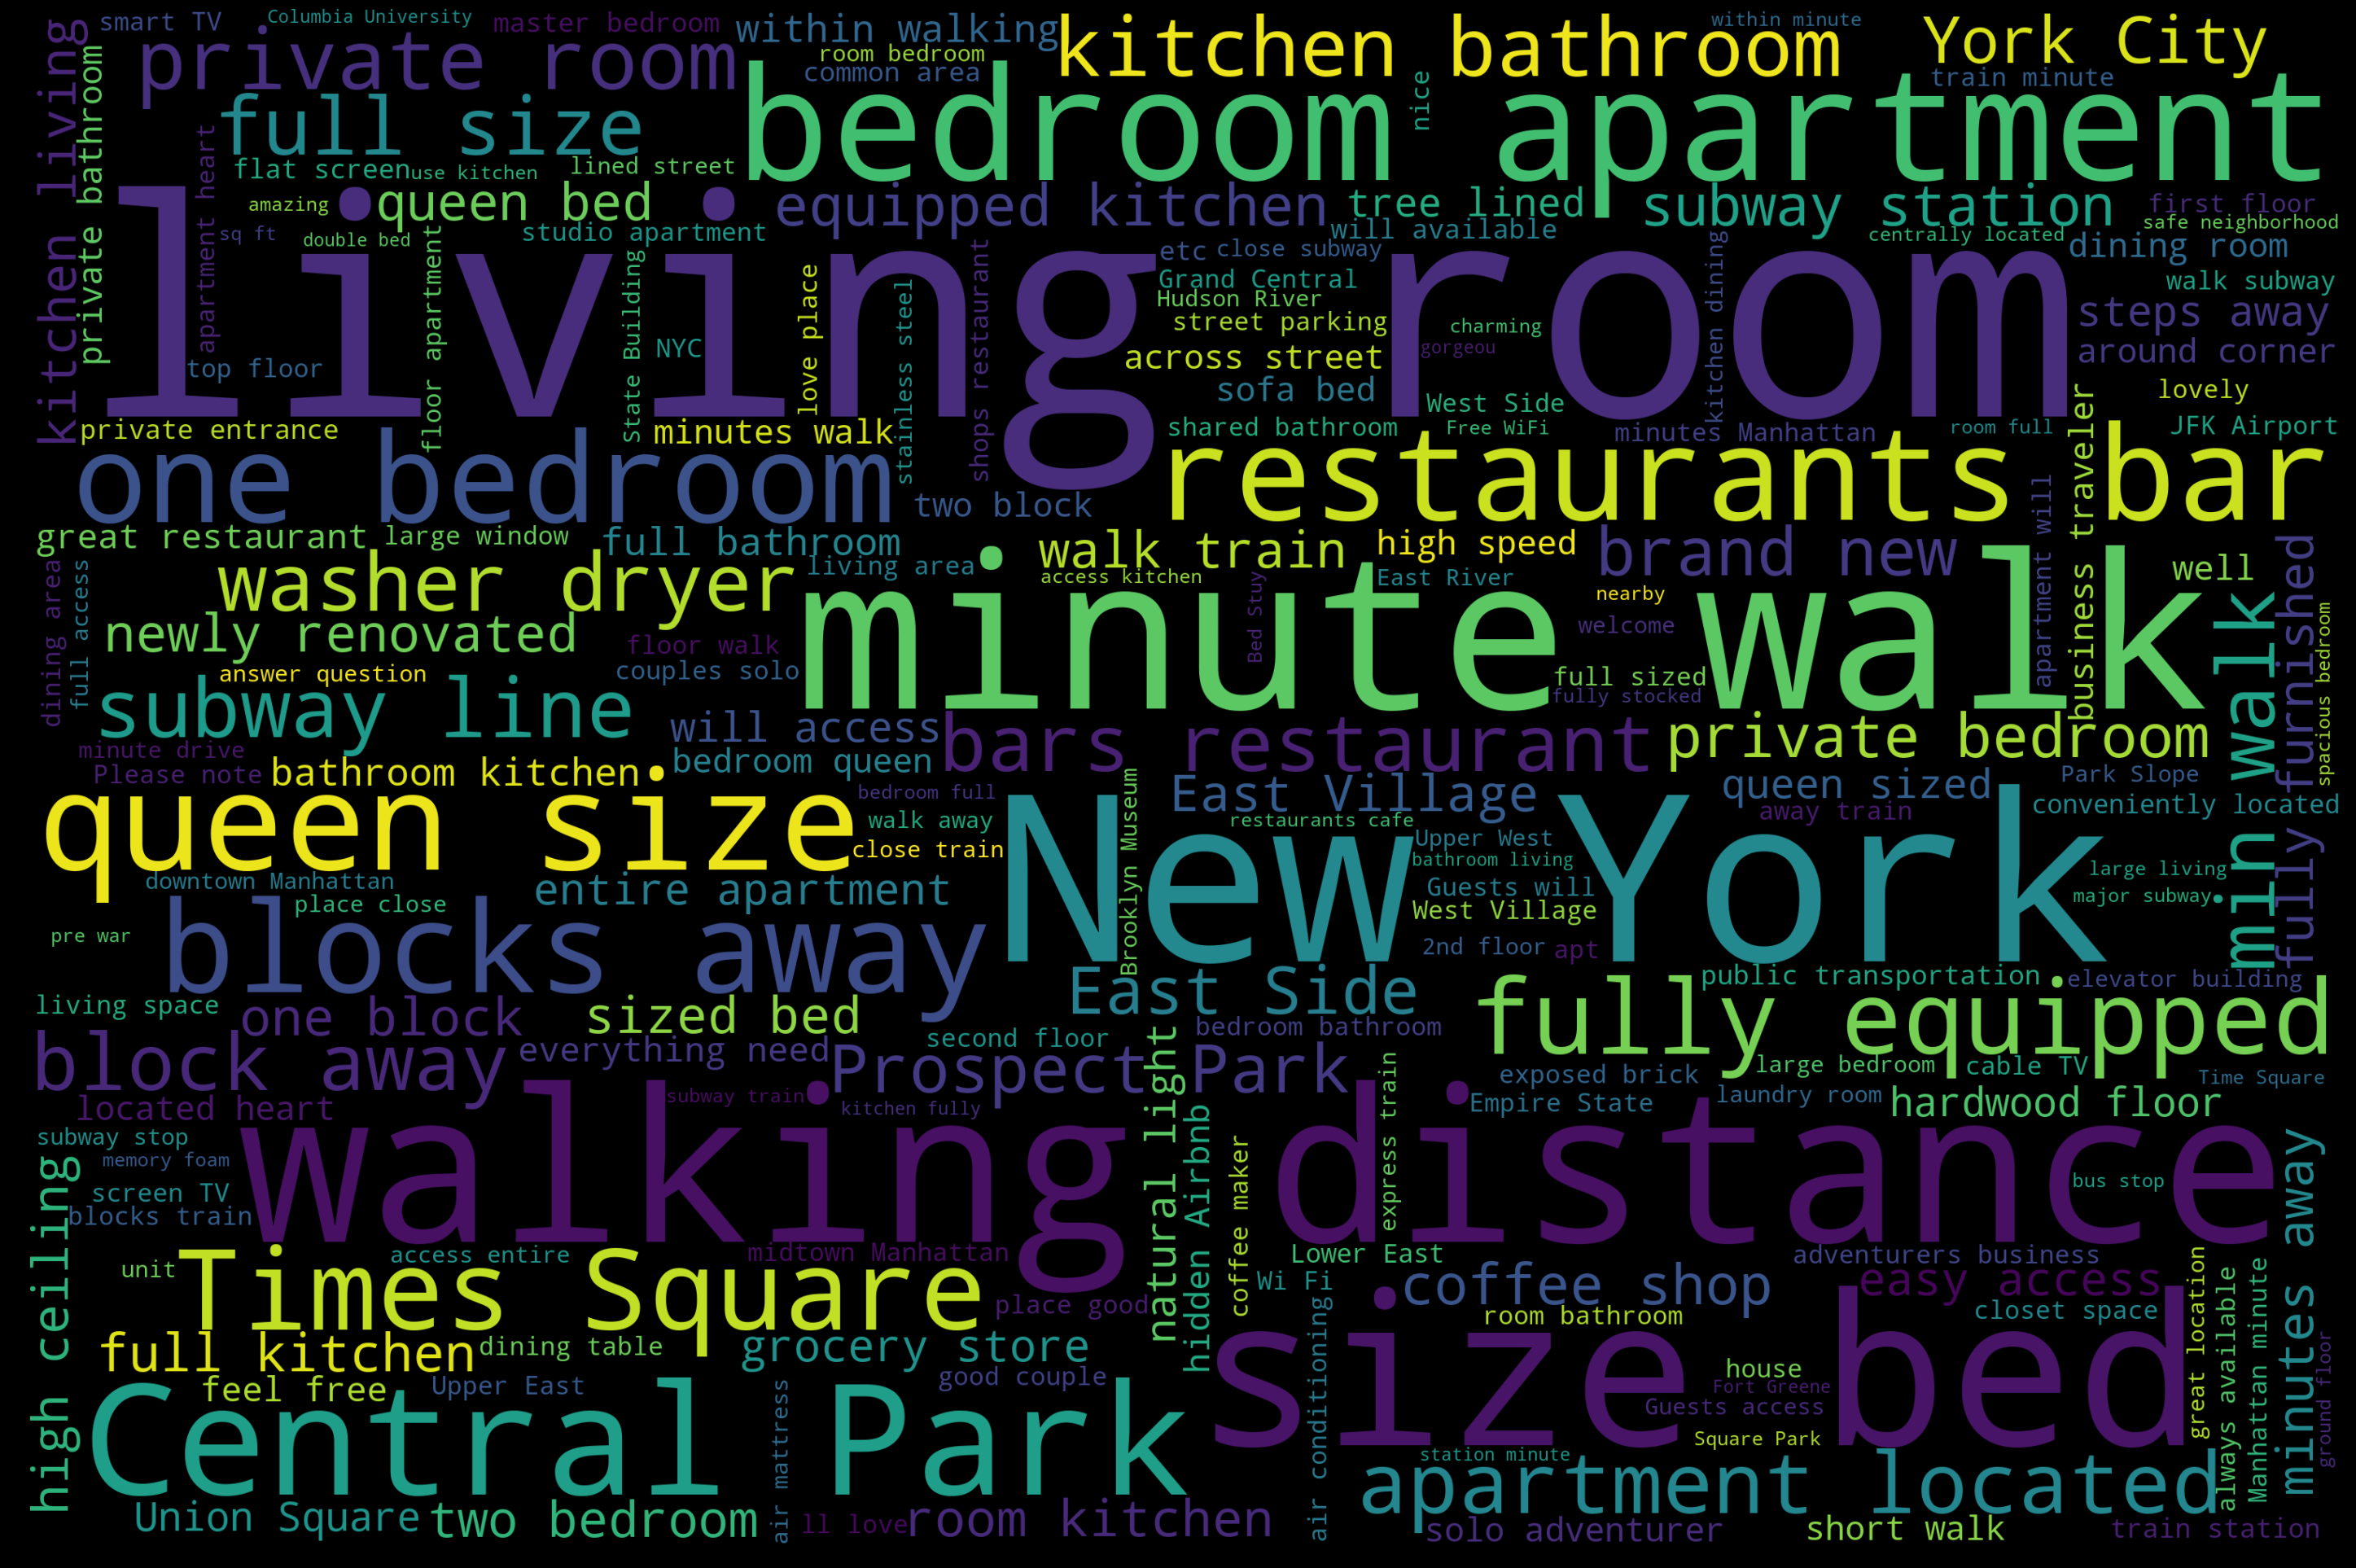

In [197]:
#need to install wordcloud on Conda
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

wordcloud = WordCloud(max_font_size=None, max_words=200, 
                      width=3000, height=2000,
                      background_color = "black" ,
                      stopwords=STOPWORDS).generate(str(df_text['text'].str.cat(sep = ' ')))

fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [198]:
#Replacing nas in text and dropping nas as done for original df to match shape
df_text['price']= df_text.price.map(lambda x: locale.atof(x.strip('$')))

df_text.drop(df_text[ (df_text.price > threshold) | (df_text.price == 0) ].index, axis=0, inplace=True)
df_text.dropna(subset=['bathrooms', 'bedrooms', 'cancellation_policy','beds',], inplace=True)

#All lowercase and remove special characters
df_text['text'] = df_text['text'].str.lower()
df_text['text'] = df_text['text'].str.replace('\W', ' ')


In [199]:
#Private 
df_text['private'] = pd.np.where(df_text['text'].str.contains("private"),1,0)
np.corrcoef(df_text['private'], df['price'])

array([[ 1.        , -0.10512582],
       [-0.10512582,  1.        ]])

In [200]:
#New
df_text['new'] = pd.np.where(df_text['text'].str.contains("new"),1,0)
np.corrcoef(df_text['new'], df['price'])

array([[1.        , 0.10453542],
       [0.10453542, 1.        ]])

In [201]:
#Luxury
df_text['luxury'] = pd.np.where(df_text['text'].str.contains("luxury"),1,0)
np.corrcoef(df_text['luxury'], df['price'])

array([[1.        , 0.15662296],
       [0.15662296, 1.        ]])

In [202]:
#Square
df_text['square'] = pd.np.where(df_text['text'].str.contains("square"),1,0)
np.corrcoef(df_text['square'], df['price'])

array([[1.        , 0.10275949],
       [0.10275949, 1.        ]])

In [203]:
#Fully Equipped
df_text['fully'] = pd.np.where(df_text['text'].str.contains("fully"),1,0)
df_text['equipped'] = pd.np.where(df_text['text'].str.contains("equipped"),1,0)

df_text['fully_equipped'] = df_text['equipped'] + df_text['fully']
np.corrcoef(df_text['fully_equipped'], df['price'])

array([[1.        , 0.11560007],
       [0.11560007, 1.        ]])

In [204]:
#Create columns in main df with high correkation 
df['private'] = df_text['private']
df['new'] = df_text['new']
df['luxury'] = df_text['luxury'] 
df['square'] = df_text['square'] 
df['fully_equipped'] = df_text['fully_equipped']

In [205]:
print("The dataset has {} rows and {} columns - after feature engineering.".format(*df.shape))

The dataset has 48376 rows and 217 columns - after feature engineering.


# 3. Data Understanding: Exploratory Data Analysis

Please use df_raw for visualization involving categorical data. And use df for correlation.

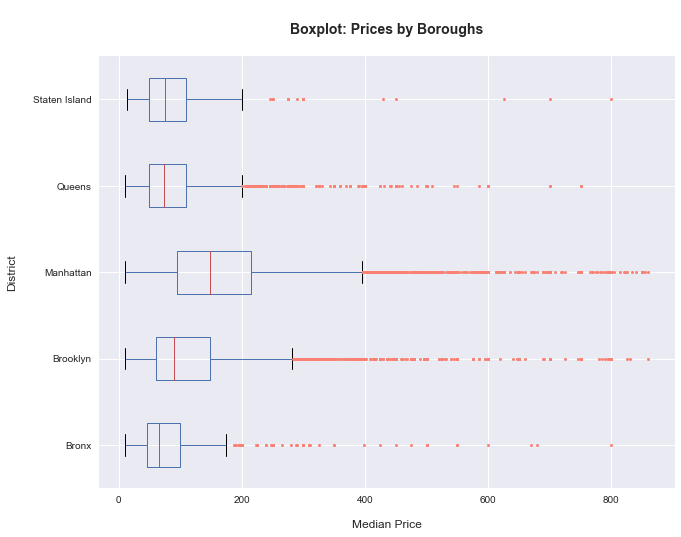

In [206]:
# Boxplot of prices by Neibourhood. Should we exclude more extreme values?
red_square = dict(markerfacecolor='salmon', markeredgecolor='salmon', marker='.')

df_raw.boxplot(column='price', by='neighbourhood_group_cleansed', 
           flierprops=red_square, vert=False, figsize=(10,8))

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nBoxplot: Prices by Boroughs\n', fontsize=14, fontweight='bold')

# get rid of automatic boxplot title
plt.suptitle('');

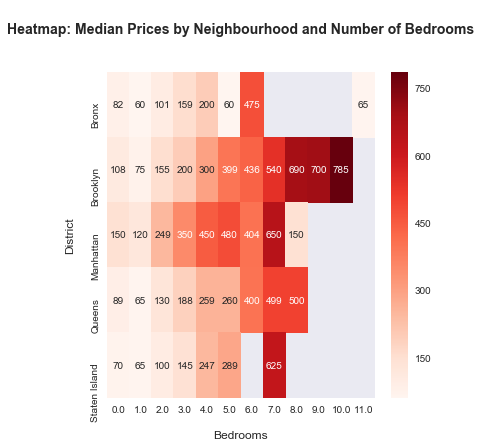

In [207]:
# Price by the number of bedrroms.
plt.figure(figsize=(6,6))
sns.heatmap(df_raw.groupby(['neighbourhood_group_cleansed', 'bedrooms']).price.median().unstack(), 
            cmap='Reds', annot=True, fmt=".0f")

plt.xlabel('\nBedrooms', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nHeatmap: Median Prices by Neighbourhood and Number of Bedrooms\n\n', fontsize=14, fontweight='bold');

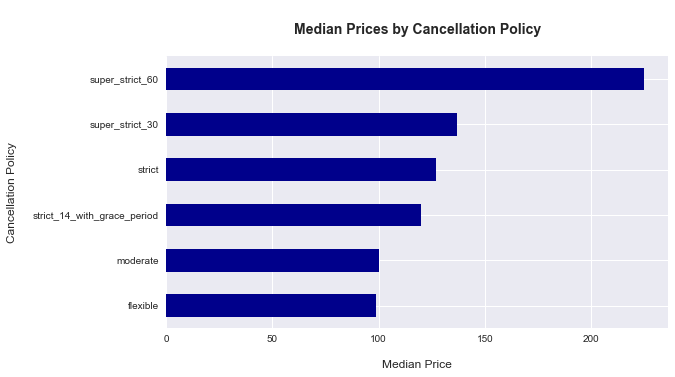

In [208]:
# Price by Cancellation Policy
# group_by cancellation policy, take the median price and store new values in sub_df 
df_raw_grouped = pd.DataFrame(df_raw.groupby(['cancellation_policy'])['price'].agg(np.median))
df_raw_grouped.reset_index(inplace=True)

# plot this 
df_raw_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='cancellation_policy', y='price', 
                figsize=(9,5), legend=False, color='darkblue')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('Cancellation Policy\n', fontsize=12)
plt.title('\nMedian Prices by Cancellation Policy\n', fontsize=14, fontweight='bold');

## K-Means Clustering


In [209]:
corrmatrix = df.corr()
corrmatrix_y = corrmatrix['price'].sort_values(ascending=False)
print("max correlation: " + str(max(corrmatrix_y[corrmatrix_y < 1])) + 
      " , min correlation: " + str(min(corrmatrix_y)))
print()
print(corrmatrix_y.head(5))

max correlation: 0.5400746199598051 , min correlation: -0.47570770348212876

price                        1.000000
accommodates                 0.540075
room_type_Entire home/apt    0.506942
beds                         0.411320
TotalRooms                   0.403145
Name: price, dtype: float64


In [210]:
# Creat a copy of the original dataframe and define features/target
df2=df.copy()
df2.columns.get_loc('price')
features = df2.copy().drop(df2.columns[6], axis=1)
target = df2.iloc[:, 6]

In [211]:
# Standardizing the features
from sklearn.preprocessing import StandardScaler as sc
sc=sc()
x = pd.DataFrame(sc.fit_transform(features),columns = features.columns)

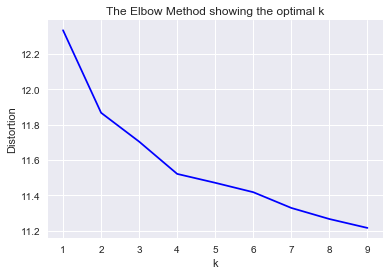

In [213]:
######################################## k-means Elbow Method (NTK) ########################################


# Elbow method
from sklearn.cluster import KMeans 
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=41).fit(x)
    kmeanModel.fit(x)
    distortions.append(sum(np.min(cdist(x, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / x.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Clustering with original feature set

In [214]:
# Choose number of clusters to be 6 based on elbow method.
clusters = 6
# Clustering using original features.
kmeans = KMeans(n_clusters = clusters,random_state=30) 
kmeans.fit(x) 
uniqueValues, indicesList = np.unique(kmeans.labels_, return_counts=True)
print('Unique Values : ', uniqueValues)
print('Indices of Unique Values : ', indicesList)

Unique Values :  [0 1 2 3 4 5]
Indices of Unique Values :  [ 3232 11300  2257   957 16746 13884]


### Clustering with PCA technique

In [215]:
# Use PCA to shrink dimensions
from sklearn.decomposition import PCA 
pca = PCA(3) 
pca.fit(x) 
pca_data = pd.DataFrame(pca.transform(x)) 
print(pca_data.head())

          0         1         2
0  9.018918  1.819072  1.017128
1 -4.924907  1.375391  1.914332
2  4.022751 -2.870801 -0.300119
3 -0.977602 -1.152369  0.700271
4  0.034068  0.196622 -0.954597


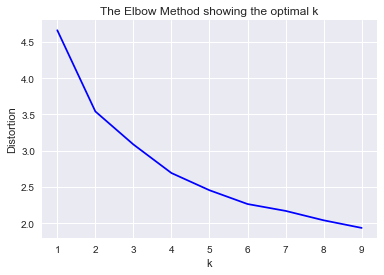

In [216]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(pca_data)
    kmeanModel.fit(pca_data)
    distortions.append(sum(np.min(cdist(pca_data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / x.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [217]:
# Choose number of clusters to be 6 based on elbow method.
clusters_pca = 6
# Clustering using 3 PCA features.
kmeans_pca = KMeans(n_clusters = clusters_pca, random_state=21) 
kmeans_pca.fit(pca_data) 
print(kmeans_pca.labels_)
# Get a tuple of unique values & their first index location from a numpy array
uniqueValues_pca, indicesList_pca = np.unique(kmeans_pca.labels_, return_counts=True)
print('Unique Values : ', uniqueValues_pca)
print('Indices of Unique Values : ', indicesList_pca)

[2 4 1 ... 2 4 2]
Unique Values :  [0 1 2 3 4 5]
Indices of Unique Values :  [10035  4225  2245 11140 13132  7599]


In [218]:
df2['clusters_kmeans'] = kmeans.labels_
df2['clusters_pca_kmeans'] = kmeans_pca.labels_

In [219]:
# Check the correlation between our clusters and price
cc = df2.loc[:, ['clusters_kmeans', 'clusters_pca_kmeans', 'price']]
c_corrmatrix = cc.corr()
c2_corrmatrix = c_corrmatrix['price'].sort_values(ascending=False)
print(c2_corrmatrix.head())

price                  1.000000
clusters_kmeans       -0.183595
clusters_pca_kmeans   -0.376300
Name: price, dtype: float64


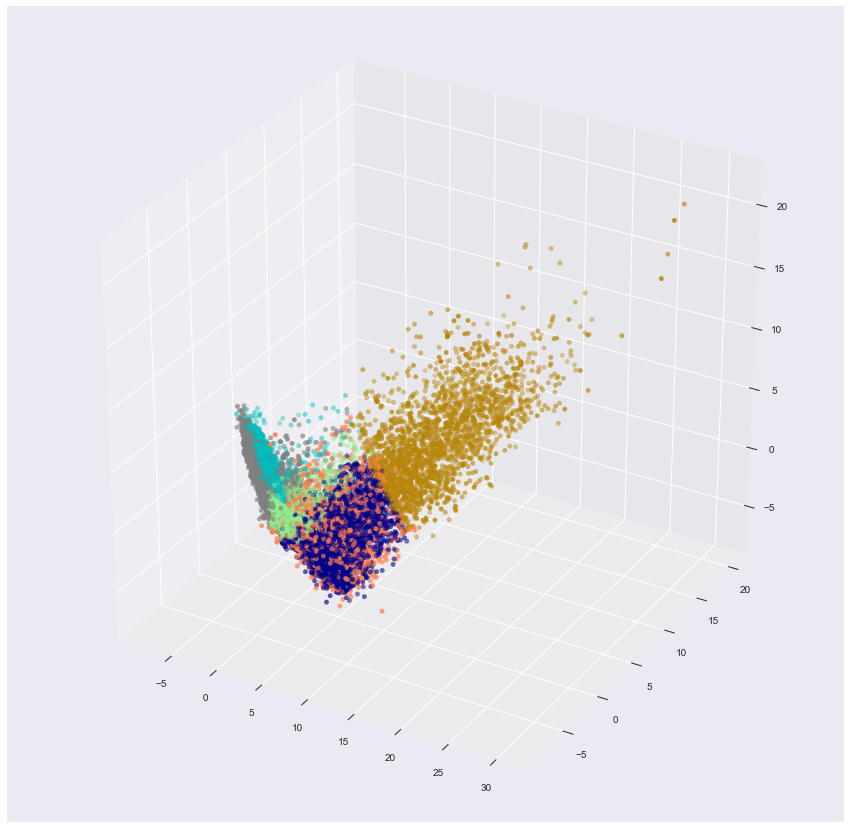

In [221]:
# Visualize our 6 PCA-features-based clusters
# This is difficult to interpret. Might want to use 3 most correlated features before PCA to visualize.
from matplotlib import colors as mcolors 
import math 
   
''' Generating different colors in ascending order  
                                of their hsv values '''
colors = list(zip(*sorted(( 
                    tuple(mcolors.rgb_to_hsv( 
                          mcolors.to_rgba(color)[:3])), name) 
                     for name, color in dict( 
                            mcolors.BASE_COLORS, **mcolors.CSS4_COLORS 
                                                      ).items())))[1] 

# number of steps to taken generate n(clusters) colors 
skips = math.floor(len(colors[5 : -5])/clusters) 
cluster_colors = colors[5 : -5 : skips] 

from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt 


fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')
ax.scatter(pca_data[0], pca_data[1], pca_data[2], 
        c = list(map(lambda label : cluster_colors[label], 
                                            kmeans_pca.labels_))) 

#str_labels = list(map(lambda label:'% s' % label, kmeans.labels_)) 

#list(map(lambda data1, data2, data3, str_label: 
#        ax.text(data1, data2, data3, s = str_label, size = 16.5, 
#        zorder = 20, color = 'k'), pca_data[0], pca_data[1], 
#        pca_data[2], str_labels)) 

plt.show() 
plt.show()

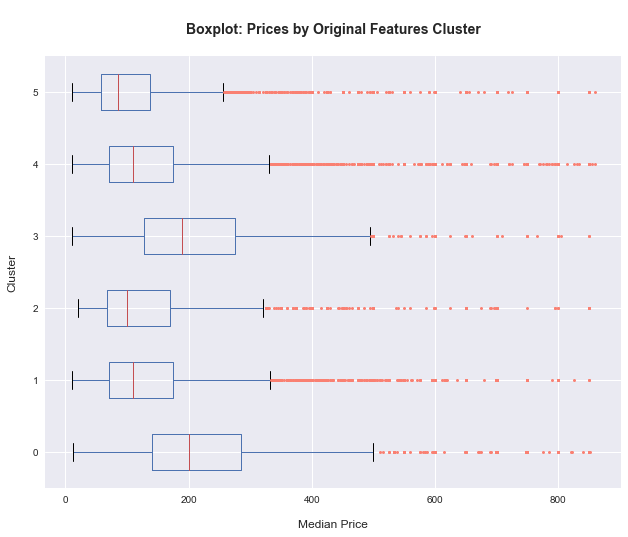

In [222]:
# Boxplot of prices by Neibourhood. Should we exclude more extreme values?
red_square = dict(markerfacecolor='salmon', markeredgecolor='salmon', marker='.')

df2.boxplot(column='price', by='clusters_kmeans', 
           flierprops=red_square, vert=False, figsize=(10,8))

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('Cluster\n', fontsize=12)
plt.title('\nBoxplot: Prices by Original Features Cluster\n', fontsize=14, fontweight='bold')

# get rid of automatic boxplot title
plt.suptitle('');

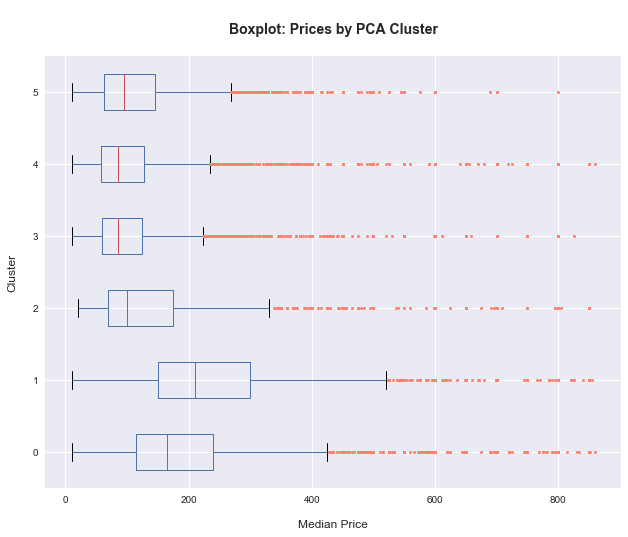

In [223]:
# Boxplot of prices by Neibourhood. Should we exclude more extreme values?
red_square = dict(markerfacecolor='salmon', markeredgecolor='salmon', marker='.')

df2.boxplot(column='price', by='clusters_pca_kmeans', 
           flierprops=red_square, vert=False, figsize=(10,8))

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('Cluster\n', fontsize=12)
plt.title('\nBoxplot: Prices by PCA Cluster\n', fontsize=14, fontweight='bold')

# get rid of automatic boxplot title
plt.suptitle('');

We then devided the clusters based on original features into two groups: High Price Group and Low Price Group.

We used classification tree to visualize what features contribute to high price group.

In [224]:
df3 = df2.copy()

In [225]:
df3['c_binary'] = np.where((df3['clusters_kmeans']==0) | (df3['clusters_kmeans']== 3), 1, 0)
df3['c_binary_pca'] = np.where(df3['clusters_pca_kmeans']>3, 1, 0)

In [226]:
x_cluster = df3.copy()
x_cluster.drop('price', axis=1, inplace=True)
x_cluster.drop('clusters_kmeans', axis=1, inplace=True)
x_cluster.drop('c_binary', axis=1, inplace=True)
x_cluster.drop('c_binary_pca', axis=1, inplace=True)
x_cluster.drop('clusters_pca_kmeans', axis=1, inplace=True)
y_cluster = df3['c_binary']

In [267]:
# Visualize the decision tree of how we get our clusters
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dtree=DecisionTreeClassifier(random_state=42,max_depth=3, min_samples_leaf=5, min_samples_split=2)

dtree.fit(x_cluster, y_cluster)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

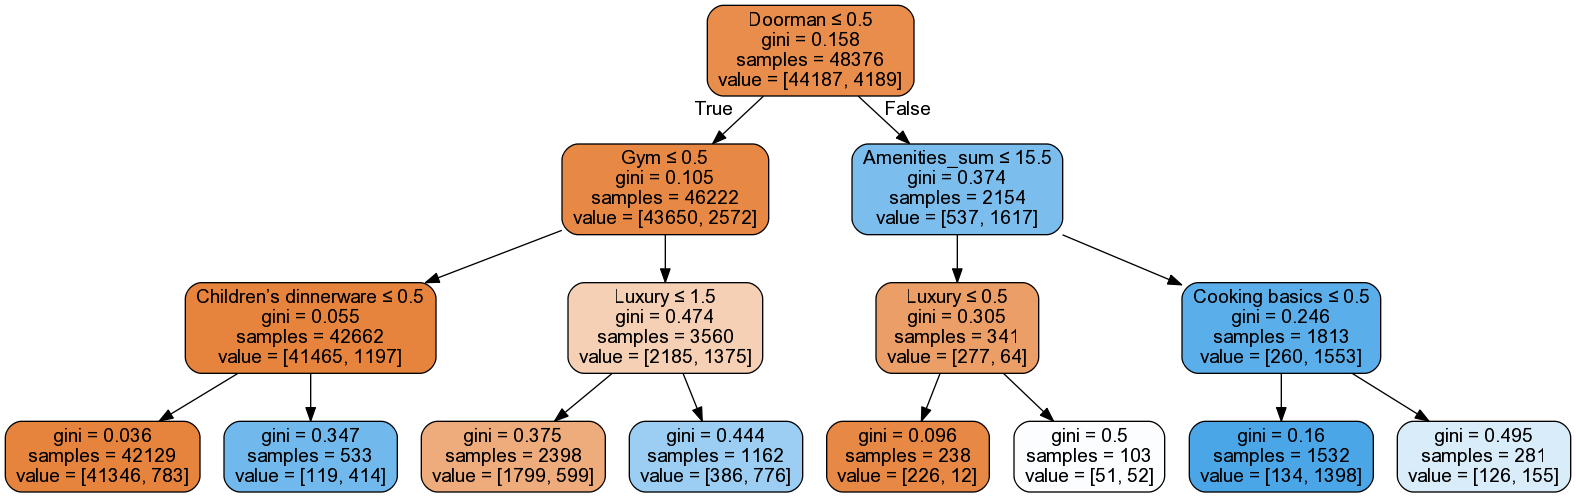

In [268]:
# How to show as the variables' actual names??
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=x_cluster.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

As a final step, we added all twelve clusters' labels into our features, and they did improve our model's generalization performance. Even though clusters maybe hard to interpret, we decided to trade comprehensivebility for accuracy.

In [229]:
# Transform clusters as features and add them back to df
cluster = df2[['clusters_kmeans','clusters_pca_kmeans']]
# Let's encode all categorical features into dummy variables.
for col in ['clusters_kmeans','clusters_pca_kmeans']:
    cluster[col] = cluster[col].astype('category')
# Recode Categorical features to binary variables
num_feats = cluster.select_dtypes(include=['float64', 'int64', 'bool']).copy()
# one-hot encoding of categorical features
cat_feats = cluster.select_dtypes(include=['category']).copy()
cat_feats = pd.get_dummies(cat_feats)
cluster = pd.concat([num_feats, cat_feats], axis=1)
print('Cluster New Features：' ,len(cluster.columns))
df=pd.concat([df,cluster],axis=1)

Cluster New Features： 12


# 4. Modeling and Evaluation

In [230]:
df.shape

(48376, 229)

In [231]:
df.iloc[:,12:42] = df.iloc[:,12:42].astype(int)

In [232]:
df.head(2)

,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,price,distance,Wifi,Heating,Essentials,Kitchen,Smoke detector,Air conditioning,Hangers,Carbon monoxide detector,TV,Shampoo,Hair dryer,Laptop friendly workspace,Iron,Hot water,Washer,Dryer,Fire extinguisher,Lock on bedroom door,First aid kit,Refrigerator,Internet,Free street parking,Dishes and silverware,Bed linens,Stove,Oven,Elevator,Microwave,Cooking basics,Family/kid friendly,Coffee maker,Cable TV,Self check-in,Buzzer/wireless intercom,No stairs or steps to enter,Extra pillows and blankets,Long term stays allowed,Private entrance,translation missing: en.hosting_amenity_50,Host greets you,Luggage dropoff allowed,translation missing: en.hosting_amenity_49,Dishwasher,Pets allowed,Lockbox,Private living room,24-hour check-in,Paid parking off premises,Gym,Safety card,Bathtub,Breakfast,Other,Well-lit path to entrance,Patio or balcony,Pets live on this property,Free parking on premises,Garden or backyard,Smoking allowed,Keypad,Wide hallways,Wide entrance for guests,Doorman,Extra space around bed,Indoor fireplace,BBQ grill,Room-darkening shades,Ethernet connection,Wide entrance,Accessible-height bed,Wheelchair accessible,Wide entryway,Hot tub,Building staff,Single level home,Cleaning before checkout,Flat path to guest entrance,Suitable for events,Children’s books and toys,Pack ’n Play/travel crib,Accessible-height toilet,Paid parking on premises,Cat(s),Window guards,Dog(s),High chair,Wide doorway to guest bathroom,Crib,Smart lock,Handheld shower head,toilet,Wide clearance to shower,Pool,Babysitter recommendations,Children’s dinnerware,Pocket wifi,Outlet covers,Game console,Waterfront,Baby bath,Fixed grab bars for shower,Stair gates,Changing table,Beach essentials,Roll-in shower,,Fixed grab bars for toilet,Baby monitor,EV charger,Fireplace guards,Beachfront,Disabled parking spot,Other pet(s),Table corner guards,Bathtub with bath chair,Lake access,Shower chair,Hot water kettle,Firm mattress,Full kitchen,Electric profiling bed,Ski-in/Ski-out,Private bathroom,Washer / Dryer,Ground floor access,Mobile hoist,Air purifier,Pool with pool hoist,Kitchenette,Ceiling hoist,host_has_profile_pic_f,host_has_profile_pic_t,host_identity_verified_f,host_identity_verified_t,neighbourhood_group_cleansed_Bronx,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island,property_type_Aparthotel,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Bus,property_type_Cabin,property_type_Camper/RV,property_type_Casa particular (Cuba),property_type_Castle,property_type_Cave,property_type_Condominium,property_type_Cottage,property_type_Dome house,property_type_Earth house,property_type_Farm stay,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Houseboat,property_type_Lighthouse,property_type_Loft,property_type_Nature lodge,property_type_Other,property_type_Resort,property_type_Serviced apartment,property_type_Tent,property_type_Timeshare,property_type_Tiny house,property_type_Townhouse,property_type_Treehouse,property_type_Villa,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_f,instant_bookable_t,is_business_travel_ready_f,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,Common_amenities,Fam_friendly,Luxury,Safety,Unwanted,Amenities_sum,Amenities30_sum,Amenities20_sum,Amenities10_sum,Not_Manhattan,TotalRooms,private,new,luxury,square,fully_equipped,clusters_kmeans_0,clusters_kmeans_1,clusters_kmeans_2,clusters_kmeans_3,clu

## 4.1 Define target variable

In [233]:
# define our target
target = df[["price"]]

# define our features 
features = df.drop(["price"], axis=1)

# define our cross validations technique
cv=KFold(n_splits=5, random_state=42)

## 4.2 Un-standardized models

In [234]:
# Linear regression with cross validation
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
mse_scores=-cross_val_score(lm,features,target,cv=cv,scoring='neg_mean_squared_error')
rmse_scores=np.sqrt(mse_scores)
print('rmse: ',rmse_scores.mean())

rmse:  636812.8010358794


In [235]:
#Ridge
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import (LinearRegression, Ridge, 
                                  Lasso, RandomizedLasso)

rid = Ridge(alpha=7)
mse_scores=-cross_val_score(rid,features,target,cv=cv,scoring='neg_mean_squared_error')
rmse_scores=np.sqrt(mse_scores)
print('rmse: ',rmse_scores.mean())

rmse:  3025.358142986759


In [236]:
#Lasso
from sklearn.linear_model import (LinearRegression, Ridge, 
                                  Lasso, RandomizedLasso)
las = Lasso(alpha=0.05)
mse_scores=-cross_val_score(las,features,target,cv=cv,scoring='neg_mean_squared_error')
rmse_scores=np.sqrt(mse_scores)
print('rmse: ',rmse_scores.mean())

rmse:  3914.844672012978


In [237]:
# k-NN with cross validation
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=15)
mse_scores=-cross_val_score(knn,features,target,cv=cv,scoring='neg_mean_squared_error')
rmse_scores=np.sqrt(mse_scores)
print('rmse: ',rmse_scores.mean())

rmse:  80.4576054244284


In [238]:
# Regression Tree with cross validation
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
mse_scores=-cross_val_score(tree,features,target,cv=cv,scoring='neg_mean_squared_error')
rmse_scores=np.sqrt(mse_scores)
print('rmse: ',rmse_scores.mean())

rmse:  97.40650140746925


## 4.3 Standardization

In [239]:
features.shape

(48376, 228)

In [240]:
cv=KFold(n_splits=5, random_state=42)
from sklearn.preprocessing import StandardScaler as sc
sc=sc()
features_std = pd.DataFrame(sc.fit_transform(features),columns = features.columns)

In [241]:
#Ridge
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import (LinearRegression, Ridge, 
                                  Lasso, RandomizedLasso)

rid = Ridge(alpha=7)
mse_scores=-cross_val_score(rid,features_std,target,cv=cv,scoring='neg_mean_squared_error')
rmse_scores=np.sqrt(mse_scores)
print('Ridge with standardized features rmse: ',rmse_scores.mean())

Ridge with standardized features rmse:  72.1467536003119


In [242]:
#Lasso
from sklearn.linear_model import (LinearRegression, Ridge, 
                                  Lasso, RandomizedLasso)
las = Lasso(alpha=0.05)
mse_scores=-cross_val_score(las,features_std,target,cv=cv,scoring='neg_mean_squared_error')
rmse_scores=np.sqrt(mse_scores)
print('Lasso with standardized features rmse: ',rmse_scores.mean())

Lasso with standardized features rmse:  72.08875105430198


In [243]:
#kNN
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=15,n_jobs=4)
mse_scores=-cross_val_score(knn,features_std,target,cv=cv,scoring='neg_mean_squared_error')
rmse_scores=np.sqrt(mse_scores)
print('k-NN with standardized features rmse: ',rmse_scores.mean())

k-NN with standardized features rmse:  78.57000950895339


In [244]:
#Tree
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
mse_scores=-cross_val_score(tree,features_std,target,cv=cv,scoring='neg_mean_squared_error')
rmse_scores=np.sqrt(mse_scores)
print('Regression tree with standardized features rmse: ',rmse_scores.mean())

Regression tree with standardized features rmse:  97.65774876421911


Standardization seems to work better for k-NN and linear models. We will keep using standardization for them.

## 4.4 Feature Selection

### The first thing we try is selecting features based on correlation.
###  We keep the feature with absolute correlation values larger than 1.

In [246]:
# Look at correlation again. These features don't include cluster features.
corrmatrix_y = corrmatrix['price'].sort_values(ascending=False)
print("max correlation: " + str(max(corrmatrix_y[corrmatrix_y < 1])) + 
      " , min correlation: " + str(min(corrmatrix_y)))
print()
print(corrmatrix_y.head(42))
print(corrmatrix_y.tail(17))

max correlation: 0.5400746199598051 , min correlation: -0.47570770348212876

price                                     1.000000
accommodates                              0.540075
room_type_Entire home/apt                 0.506942
beds                                      0.411320
TotalRooms                                0.403145
bedrooms                                  0.393500
neighbourhood_group_cleansed_Manhattan    0.301098
Fam_friendly                              0.290353
Common_amenities                          0.289225
bathrooms                                 0.247001
TV                                        0.238822
Luxury                                    0.229786
Cable TV                                  0.214930
Dryer                                     0.208754
Safety                                    0.208108
Elevator                                  0.204003
Washer                                    0.203924
Dishwasher                                0.198466
Ameni

In [248]:
features_cor = df[['accommodates',
                     'room_type_Entire home/apt',
                     'beds',
                     'bedrooms',
                     'neighbourhood_group_cleansed_Manhattan',
                     'bathrooms',
                     'TV',
                     'Cable TV',
                     'Dishwasher',
                     'Dryer',
                     'Elevator',
                     'Washer',
                     'Gym',
                     'Doorman',
                     'Building staff',
                     'Bathtub',
                     'Pool',
                     'Indoor fireplace',
                     'Family/kid friendly',
                     'Air conditioning',
                     'Hair dryer',
                     'Iron',
                     'property_type_Resort',
                     'Shampoo',
                     'Free street parking',
                     'room_type_Shared room',
                     'neighbourhood_group_cleansed_Queens',
                     'Lock on bedroom door',
                     'neighbourhood_group_cleansed_Brooklyn',
                     'distance',
                     'room_type_Private room',
                     'is_business_travel_ready_f',
                     'Common_amenities',
                     'Fam_friendly',
                    'Luxury','Safety',
                    'Unwanted',
                    'Amenities_sum',
                    'Amenities30_sum',
                    'Not_Manhattan',
                    'Amenities10_sum',
                      'clusters_pca_kmeans_1',
                      'clusters_pca_kmeans_2',
                      'clusters_pca_kmeans_3',
                      'clusters_pca_kmeans_4',
                      'clusters_pca_kmeans_5',
                      'clusters_pca_kmeans_0',
                      'clusters_kmeans_1',
                      'clusters_kmeans_2',
                      'clusters_kmeans_3',
                      'clusters_kmeans_4',
                      'clusters_kmeans_5',
                      'clusters_kmeans_0',
                      'TotalRooms',
                    'private','new','luxury','square','fully_equipped']]

In [249]:
features_cor.shape

(48376, 59)

In [250]:
from sklearn.preprocessing import StandardScaler as sc
sc=sc()
features_cor_std = pd.DataFrame(sc.fit_transform(features_cor),columns = features_cor.columns)

In [251]:
features_cor_std.shape

(48376, 59)

In [252]:
cv=KFold(n_splits=5, random_state=42)

In [253]:
#Ridge
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import (LinearRegression, Ridge, 
                                  Lasso, RandomizedLasso)

rid = Ridge(alpha=7)
mse_scores=-cross_val_score(rid,features_cor_std,target,cv=cv,scoring='neg_mean_squared_error')
rmse_scores=np.sqrt(mse_scores)
print('Ridge with (step 1) selected features rmse: ',rmse_scores.mean())

Ridge with (step 1) selected features rmse:  72.82042427442015


In [254]:
#Lasso
from sklearn.linear_model import (LinearRegression, Ridge, 
                                  Lasso, RandomizedLasso)
las = Lasso(alpha=0.05)
mse_scores=-cross_val_score(las,features_cor_std,target,cv=cv,scoring='neg_mean_squared_error')
rmse_scores=np.sqrt(mse_scores)
print('Lasso with (step 1) selected features rmse: ',rmse_scores.mean())

Lasso with (step 1) selected features rmse:  72.81400832386456


In [255]:
#kNN
knn = KNeighborsRegressor(n_neighbors=15)
mse_scores=-cross_val_score(knn,features_cor_std,target,cv=cv,scoring='neg_mean_squared_error')
rmse_scores=np.sqrt(mse_scores)
print('k-NN with (step 1) selected features rmse: ',rmse_scores.mean())

k-NN with (step 1) selected features rmse:  73.68161862382188


In [256]:
#Tree
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
mse_scores=-cross_val_score(tree,features_cor,target,cv=cv,scoring='neg_mean_squared_error')
rmse_scores=np.sqrt(mse_scores)
print('Regression tree (step 1) with selected features rmse: ',rmse_scores.mean())

Regression tree (step 1) with selected features rmse:  98.06325432659656


### The second thing we try is to use a stepwise auto-selecting method. The package is called "mlxtend". You need to install both "mlxtend" and "joblib" in Anaconda in order to run it.

In [277]:
# http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/
#kNN
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
knn = KNeighborsRegressor(n_neighbors=15,n_jobs=5)
sfs1 = SFS(knn,
           # Change the features number accordingly.
           k_features=30,
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='neg_mean_squared_error',
           cv=cv,
           n_jobs=-1)

sfs1 = sfs1.fit(features_cor_std, target)
pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:  2.7min finished

[2019-10-06 16:47:20] Features: 1/30 -- score: -8335.132093373513[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:   59.3s finished

[2019-10-06 16:48:19] Features: 2/30 -- score: -7176.595759546978[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:  1.0min finished

[2019-10-06 16:49:20] Features: 3/30 -- score: -6528.746704130628[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  56 o

[Parallel(n_jobs=-1)]: Done  24 out of  31 | elapsed:  8.5min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed: 10.3min finished

[2019-10-06 19:29:09] Features: 29/30 -- score: -5086.6605604985325[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  8.7min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 10.3min finished

[2019-10-06 19:39:31] Features: 30/30 -- score: -5104.091278856207

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,-8335.13,1102.68,"[-7971.160834137155, -7520.295623772609, -7644...","(0,)","(accommodates,)",857.919,428.959
2,-7176.6,830.031,"[-7178.683026043821, -6531.589318173988, -6448...","(0, 39)","(accommodates, Not_Manhattan)",645.792,322.896
3,-6528.75,672.535,"[-6694.254347526526, -6100.437188630492, -6081...","(0, 1, 39)","(accommodates, room_type_Entire home/apt, Not_...",523.255,261.627
4,-5846.54,579.662,"[-6184.415519728079, -5547.585093769739, -5206...","(0, 1, 39, 53)","(accommodates, room_type_Entire home/apt, Not_...",450.997,225.498
5,-5519.35,633.025,"[-5794.535879840155, -5290.855836922194, -4858...","(0, 1, 29, 39, 53)","(accommodates, room_type_Entire home/apt, dist...",492.515,246.257
6,-5337.08,589.029,"[-5689.709593036609, -5101.684720068906, -4710...","(0, 1, 29, 32, 39, 53)","(accommodates, room_type_Entire home/apt, dist...",458.285,229.142
7,-5255.38,656.782,"[-5591.692773414175, -4966.199975193798, -4625...","(0, 1, 12, 29, 32, 39, 53)","(accommodates, room_type_Entire home/apt, Gym,...",510.999,255.499
8,-5189.32,596.328,"[-5492.236784254284, -4888.535722997416, -4597...","(0, 1, 12, 29, 32, 35, 39, 53)","(accommodates, room_type_Entire home/apt, Gym,...",463.964,231.982
9,-5134.83,585.035,"[-5454.497270681181, -4862.256491070916, -4536...","(0, 1, 12, 28, 29, 32, 35, 39, 53)","(accommodates, room_type_Entire home/apt, Gym,...",455.177,227.589
10,-5091.93,616.956,"[-5434.700425795783, -4813.64143646282, -4417....","(0, 1, 12, 22, 28, 29, 32, 35, 39, 53)","(accommodates, room_type_Entire home/apt, Gym,...",480.013,240.007


In [278]:
output = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
features_fw = output[output.avg_score==max(output.avg_score)].feature_names
features_fw_knn = list(list(features_fw)[0])
features_fw_knn = features_cor_std[features_fw_knn]

In [288]:
print('Chosen features for K-NN:',features_fw_knn.columns)

Chosen features for K-NN: Index(['accommodates', 'room_type_Entire home/apt', 'bedrooms',
       'neighbourhood_group_cleansed_Manhattan', 'bathrooms', 'TV', 'Gym',
       'Pool', 'property_type_Resort', 'Free street parking',
       'room_type_Shared room', 'neighbourhood_group_cleansed_Queens',
       'neighbourhood_group_cleansed_Brooklyn', 'distance',
       'room_type_Private room', 'is_business_travel_ready_f',
       'Common_amenities', 'Safety', 'Not_Manhattan', 'Amenities10_sum',
       'TotalRooms'],
      dtype='object')


In [280]:
#kNN
knn = KNeighborsRegressor(n_neighbors=15)
mse_scores=-cross_val_score(knn,features_fw_knn,target,cv=cv,scoring='neg_mean_squared_error')
rmse_scores=np.sqrt(mse_scores)
print('k-NN with standardized and (step 2) selected features rmse: ',rmse_scores.mean())

k-NN with standardized and (step 2) selected features rmse:  70.8720729791407


In [257]:
#Ridge
#Feature Selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
rid = Ridge(alpha=7)
sfs2 = SFS(rid,
           # Change the features number accordingly.
           k_features=59, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='neg_mean_squared_error',
           cv=cv,
           n_jobs=4)

sfs2 = sfs2.fit(features_cor_std, target)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  36 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done  59 out of  59 | elapsed:    4.5s finished

[2019-10-06 11:52:15] Features: 1/59 -- score: -7976.382083287662[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  58 out of  58 | elapsed:    0.5s finished

[2019-10-06 11:52:15] Features: 2/59 -- score: -6927.420036381329[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  57 out of  57 | elapsed:    0.6s finished

[2019-10-06 11:52:16] Features: 3/59 -- score: -6355.874040353695[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  56 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=4)]: Done  56 out of  56 | elapsed:    0.7s finished

[2019-10-06 11:52:17] Features: 4/59 -- score: -6009.848202426663[Parallel(n_job

[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed:    1.6s finished

[2019-10-06 11:53:09] Features: 36/59 -- score: -5300.075091578874[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  23 out of  23 | elapsed:    1.6s finished

[2019-10-06 11:53:11] Features: 37/59 -- score: -5300.07486285227[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  22 out of  22 | elapsed:    1.6s finished

[2019-10-06 11:53:12] Features: 38/59 -- score: -5300.07486285227[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  21 out of  21 | elapsed:    1.6s finished

[2019-10-06 11:53:14] Features: 39/59 -- score: -5300.075226944822[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    1.4s finished

[2019-10-06 11:53:16] Features: 40/59 -- score: -5300.1274422325105[Parallel(n_jobs

In [258]:
pd.DataFrame.from_dict(sfs2.get_metric_dict()).T

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,-7976.38,1047.77,"[-7666.477797844434, -7335.863654661938, -7127...","(0,)","(accommodates,)",815.2,407.6
2,-6927.42,656.605,"[-7003.235031724296, -6564.288395466339, -6267...","(0, 4)","(accommodates, neighbourhood_group_cleansed_Ma...",510.861,255.43
3,-6355.87,631.261,"[-6357.695511957034, -6110.045448525145, -5770...","(0, 1, 4)","(accommodates, room_type_Entire home/apt, neig...",491.142,245.571
4,-6009.85,562.532,"[-5980.568027242325, -5773.361670636852, -5505...","(0, 1, 4, 53)","(accommodates, room_type_Entire home/apt, neig...",437.669,218.835
5,-5802.16,567.61,"[-5853.120639589395, -5526.177942276066, -5327...","(0, 1, 4, 12, 53)","(accommodates, room_type_Entire home/apt, neig...",441.62,220.81
6,-5703.23,656.92,"[-5854.348811373485, -5324.959020884106, -5069...","(0, 1, 4, 12, 22, 53)","(accommodates, room_type_Entire home/apt, neig...",511.106,255.553
7,-5617.64,670.605,"[-5785.71919296734, -5243.89782669926, -4956.0...","(0, 1, 4, 12, 22, 32, 53)","(accommodates, room_type_Entire home/apt, neig...",521.753,260.877
8,-5564,672.189,"[-5795.30997186567, -5191.498668207898, -4900....","(0, 1, 4, 12, 22, 32, 53, 56)","(accommodates, room_type_Entire home/apt, neig...",522.986,261.493
9,-5516.32,667.811,"[-5755.809906102755, -5161.683700774729, -4842...","(0, 1, 4, 12, 22, 24, 32, 53, 56)","(accommodates, room_type_Entire home/apt, neig...",519.579,259.79
10,-5485.62,659.989,"[-5712.526902846954, -5151.902283848669, -4809...","(0, 1, 4, 12, 22, 24, 29, 32, 53, 56)","(accommodates, room_type_Entire home/apt, neig...",513.494,256.747


In [259]:
output2 = pd.DataFrame.from_dict(sfs2.get_metric_dict()).T
features_fw2 = output2[output2.avg_score==max(output2.avg_score)].feature_names
features_fw_rid = list(list(features_fw2)[0])
features_fw_rid = features_cor_std[features_fw_rid]

In [260]:
print('Chosen features for Ridge:',features_fw_rid.columns)

Chosen features for Ridge: Index(['accommodates', 'room_type_Entire home/apt', 'beds',
       'neighbourhood_group_cleansed_Manhattan', 'TV', 'Cable TV',
       'Dishwasher', 'Dryer', 'Elevator', 'Washer', 'Gym', 'Building staff',
       'Pool', 'Indoor fireplace', 'Family/kid friendly', 'Air conditioning',
       'Hair dryer', 'Iron', 'property_type_Resort', 'Shampoo',
       'Free street parking', 'room_type_Shared room',
       'neighbourhood_group_cleansed_Queens',
       'neighbourhood_group_cleansed_Brooklyn', 'distance',
       'room_type_Private room', 'is_business_travel_ready_f',
       'Common_amenities', 'Fam_friendly', 'Safety', 'Unwanted',
       'Amenities30_sum', 'Not_Manhattan', 'Amenities10_sum',
       'clusters_pca_kmeans_1', 'clusters_pca_kmeans_2',
       'clusters_pca_kmeans_3', 'clusters_pca_kmeans_4', 'clusters_kmeans_3',
       'clusters_kmeans_4', 'clusters_kmeans_5', 'clusters_kmeans_0',
       'TotalRooms', 'new', 'luxury', 'square', 'fully_equipped'],
    

In [261]:
#Ridge
rid = Ridge(alpha=7)
mse_scores=-cross_val_score(rid,features_fw_rid,target,cv=cv,scoring='neg_mean_squared_error')
rmse_scores=np.sqrt(mse_scores)
print('Ridge with standardized and (step 2) selected features rmse: ',rmse_scores.mean())

Ridge with standardized and (step 2) selected features rmse:  72.71759085848115


In [263]:
#Tree
tree = DecisionTreeRegressor()
sfs3 = SFS(tree,
           # Change the features number accordingly.
           k_features=59, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='neg_mean_squared_error',
           cv=cv,
           n_jobs=4)

sfs3 = sfs3.fit(features_cor, target)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  52 out of  59 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  59 out of  59 | elapsed:    0.9s finished

[2019-10-06 11:55:08] Features: 1/59 -- score: -7938.2287660572065[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  58 out of  58 | elapsed:    3.1s finished

[2019-10-06 11:55:11] Features: 2/59 -- score: -6770.118336450835[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  57 out of  57 | elapsed:    1.0s finished

[2019-10-06 11:55:12] Features: 3/59 -- score: -6160.598397999753[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 out of  56 | elapsed:    1.2s finished

[2019-10-06 11:55:14] Features: 4/59 -- score: -5686.457977547626[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    5.8s finished

[2019-10-06 11:57:19] Features: 35/59 -- score: -7154.349901913694[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed:    6.0s finished

[2019-10-06 11:57:26] Features: 36/59 -- score: -7375.742583383236[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  23 out of  23 | elapsed:    5.8s finished

[2019-10-06 11:57:32] Features: 37/59 -- score: -7563.916437513804[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  22 out of  22 | elapsed:    5.9s finished

[2019-10-06 11:57:38] Features: 38/59 -- score: -7827.32088692138[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  21 out of  21 | elapsed:    6.1s finished

[2019-10-06 11:57:44] Features: 39/59 -- score: -8044.068668336392[Parallel(n_jobs

In [264]:
pd.DataFrame.from_dict(sfs3.get_metric_dict()).T

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,-7938.23,1051.17,"[-7650.6650468928265, -7269.655962724076, -712...","(0,)","(accommodates,)",817.845,408.922
2,-6770.12,643.968,"[-7005.897473674229, -6385.79408286335, -6120....","(0, 4)","(accommodates, neighbourhood_group_cleansed_Ma...",501.029,250.514
3,-6160.6,628.794,"[-6321.62766459979, -5897.940919144735, -5596....","(0, 1, 4)","(accommodates, room_type_Entire home/apt, neig...",489.223,244.612
4,-5686.46,634.274,"[-5785.347630471368, -5294.255100157059, -5182...","(0, 1, 4, 5)","(accommodates, room_type_Entire home/apt, neig...",493.487,246.743
5,-5569.58,726.812,"[-5714.158188904811, -5127.39018710932, -5012....","(0, 1, 4, 5, 12)","(accommodates, room_type_Entire home/apt, neig...",565.485,282.742
6,-5529.49,721.25,"[-5721.937416493328, -5028.552176915344, -4930...","(0, 1, 4, 5, 12, 22)","(accommodates, room_type_Entire home/apt, neig...",561.157,280.578
7,-5515.68,716.734,"[-5715.368788315571, -4997.117082020636, -4944...","(0, 1, 4, 5, 12, 22, 28)","(accommodates, room_type_Entire home/apt, neig...",557.644,278.822
8,-5513.84,718.549,"[-5716.015026430494, -4997.117082020636, -4938...","(0, 1, 4, 5, 12, 22, 28, 31)","(accommodates, room_type_Entire home/apt, neig...",559.055,279.528
9,-5509.8,720.023,"[-5715.368788315571, -4990.018787446993, -4929...","(0, 1, 4, 5, 12, 22, 28, 31, 39)","(accommodates, room_type_Entire home/apt, neig...",560.202,280.101
10,-5523.15,723.104,"[-5735.901412060187, -5009.99922504339, -4924....","(0, 1, 4, 5, 12, 22, 26, 28, 31, 39)","(accommodates, room_type_Entire home/apt, neig...",562.599,281.3


In [265]:
output3 = pd.DataFrame.from_dict(sfs3.get_metric_dict()).T
features_fw3 = output3[output3.avg_score==max(output3.avg_score)].feature_names
features_fw_tree = list(list(features_fw3)[0])
features_fw_tree = features_cor[features_fw_tree]

In [266]:
print('Chosen features for Tree:',features_fw_tree.columns)

Chosen features for Tree: Index(['accommodates', 'room_type_Entire home/apt',
       'neighbourhood_group_cleansed_Manhattan', 'bathrooms', 'Gym',
       'property_type_Resort', 'neighbourhood_group_cleansed_Brooklyn',
       'is_business_travel_ready_f', 'Not_Manhattan'],
      dtype='object')


In [269]:
#Tree
tree = DecisionTreeRegressor()
mse_scores=-cross_val_score(tree,features_fw_tree,target,cv=cv,scoring='neg_mean_squared_error')
rmse_scores=np.sqrt(mse_scores)
print('Regression tree with (step 2) selected features rmse: ',rmse_scores.mean())

Regression tree with (step 2) selected features rmse:  74.16086277235007


## 4.5 Hyperparamter tuning with nested cross validation

In [281]:
#####################################    Set inner and outer cv   ############################################

inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
import math

In [282]:
########################################  Modelling with Decision Tree #######################################
# Choosing depth of the tree AND splitting criterion AND min_samples_leaf AND min_samples_split
gs_dt = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None], 
                              'min_samples_leaf':[1,2,3,4,5],
                              'min_samples_split':[2,3,4,5]}],
                  scoring='neg_mean_squared_error',
                  cv=inner_cv,
                  n_jobs=-1)


gs_dt = gs_dt.fit(features_fw_tree,target)
print("\n Decision Tree Model")
print("Non-nested CV RMSE: ", math.sqrt(-gs_dt.best_score_))
print("Optimal Parameter: ", gs_dt.best_params_)
print("Optimal Estimator: ", gs_dt.best_estimator_)
nested_score_gs_dt = cross_val_score(gs_dt, X=features_fw_tree, y=target, cv=outer_cv)
print("Tree: Nested CV RMSE: ",math.sqrt(-nested_score_gs_dt.mean()))


 Decision Tree Model
Non-nested CV RMSE:  72.58648706314891
Optimal Parameter:  {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
Optimal Estimator:  DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')
Tree: Nested CV RMSE:  72.58647039431361


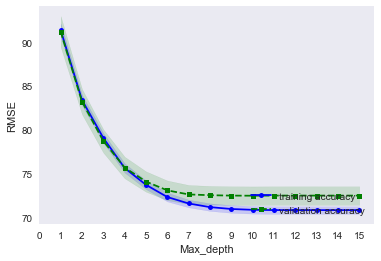

In [321]:
######################################## Import Libraries & Modules ##########################################
from sklearn.model_selection import validation_curve 
from sklearn.model_selection import ShuffleSplit
np.random.seed(42) #the seed used by the random number generator for np

##################################### Parameters - Varying Complexity ########################################

# Specify different depths of the decision tree
param_range = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

# Compute scores for an estimator with different values of a specified parameter. 
# This is similar to grid search with one parameter. 
# However, this will also compute training scores and is merely a utility for plotting the results.

####################################   Estimate Scores - Varying Complexity   ################################

cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
# Determine training and test scores for varying parameter values.
train_scores, test_scores = validation_curve( 
                estimator=DecisionTreeRegressor(criterion='mse', max_features=None,
                                               max_leaf_nodes=None, min_impurity_decrease=0.0,
                                               min_impurity_split=None, min_samples_leaf=5,
                                               min_samples_split=2, min_weight_fraction_leaf=0.0,
                                               presort=False, random_state=42, splitter='best'), 
                X=features_fw_tree,
                y=target, 
                param_name="max_depth",
                param_range=param_range,
                cv=cv,     #10-fold cross-validation
                scoring="neg_mean_squared_error", 
                n_jobs=4) # Number of CPU cores used when parallelizing over classes if multi_class=’ovr’”. This parameter is ignored when the ``solver``is set to ‘liblinear’ regardless of whether ‘multi_class’ is specified or not. If given a value of -1, all cores are used.


# Cross validation statistics for training and testing data (mean and standard deviation)
train_mean = np.mean(np.sqrt(-train_scores),axis=1) # Compute the arithmetic mean along the specified axis.
train_std = np.std(np.sqrt(-train_scores),axis=1)   # Compute the standard deviation along the specified axis.
test_mean = np.mean(np.sqrt(-test_scores),axis=1)
test_std = np.std(np.sqrt(-test_scores),axis=1)

######################################   Visualization - Fitting Graph   #####################################

# Plot train accuracy means of cross-validation for all the parameters C in param_range
plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

# Fill the area around the line to indicate the size of standard deviations of performance for the training data
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

# Plot test accuracy means of cross-validation for all the parameters C in param_range
plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

# Fill the area around the line to indicate the size of standard deviations of performance for the test data
plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

# Grid and Axes Titles
plt.rcParams["figure.facecolor"] = "w"
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Max_depth')
plt.ylabel('RMSE')
plt.xticks(np.arange(0, 16, step=1))
# plt.savefig('Fitting_graph_LR.png', dpi=300)
plt.show()           # Display the figure

In [323]:
print(train_mean,test_mean)

[91.41079455 83.40840422 79.06993115 75.62835071 73.7054326  72.3093521
 71.56810047 71.15326579 70.93987152 70.84315456 70.81409483 70.81106785
 70.81085938 70.81085919 70.81085919] [91.23580766 83.21866358 78.716523   75.681054   74.07732362 73.07067846
 72.60440297 72.51525696 72.47046809 72.45767994 72.47305551 72.47359495
 72.47258267 72.47258259 72.47258259]


In [305]:
print(np.mean(np.sqrt(-train_scores),axis=1))

[91.41079455 83.40840422 79.06993115 75.62835071 73.7054326  72.3093521
 71.56810047 71.15326579 70.93987152 70.84315456 70.81409483 70.81106785
 70.81085938 70.81085919 70.81085919]


In [283]:
############################################## Modelling with Ridge #########################################
gs_rid = GridSearchCV(estimator=Ridge(),
                  param_grid=[{'alpha': [25,10,7,4,2,1.0,0.8,0.5,0.3,0.2,0.1,0.05,0.02,0.01]}],
                  scoring='neg_mean_squared_error',
                  cv=inner_cv,
                  n_jobs=-1)


gs_rid = gs_rid.fit(features_std,target)
print("\n Ridge Model")
print("Non-nested CV RMSE: ", math.sqrt(-gs_rid.best_score_))
print("Optimal Parameter: ", gs_rid.best_params_)
print("Optimal Estimator: ", gs_rid.best_estimator_)
nested_score_gs_rid = cross_val_score(gs_rid, X=features_std, y=target, cv=outer_cv)
print("Ridge: Nested CV RMSE: ",math.sqrt(-nested_score_gs_rid.mean()))



 Ridge Model
Non-nested CV RMSE:  72.58268234995296
Optimal Parameter:  {'alpha': 25}
Optimal Estimator:  Ridge(alpha=25, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
Ridge: Nested CV RMSE:  72.58266593308659


In [284]:
############################################## Modelling with Lasso #########################################
gs_las = GridSearchCV(estimator=Lasso(),
                  param_grid=[{'alpha': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06]}],
                  scoring='neg_mean_squared_error',
                  cv=inner_cv)
             
                      

gs_las = gs_las.fit(features_std,target)
print("\n Lasso Model")
print("Non-nested CV RMSE: ", math.sqrt(-gs_las.best_score_))
print("Optimal Parameter: ", gs_las.best_params_)
print("Optimal Estimator: ", gs_las.best_estimator_)
nested_score_gs_las = cross_val_score(Lasso(alpha=0.06), X=features_std, y=target, cv=outer_cv)


 Lasso Model
Non-nested CV RMSE:  71.47800466749736
Optimal Parameter:  {'alpha': 0.06}
Optimal Estimator:  Lasso(alpha=0.06, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


In [285]:
nested_score_gs_las = cross_val_score(Lasso(alpha=0.06), X=features_std, y=target, cv=outer_cv,scoring='neg_mean_squared_error')
print("Lasso: Nested CV RMSE: ",math.sqrt(-nested_score_gs_las.mean()))

Lasso: Nested CV RMSE:  71.47798257151382


In [329]:
############################################## Modelling with kNN ###########################################
gs_knn = GridSearchCV(estimator=KNeighborsRegressor(),
                  param_grid=[{'n_neighbors': [5,7,9,11,13,15,17,19,21],
                               'weights':['uniform','distance']}],
                  scoring='neg_mean_squared_error',
                  cv=inner_cv,
                  n_jobs=4)

gs_knn = gs_knn.fit(features_fw_knn,target)  
print("\n k-NN Model")
print("Non-nested CV RMSE ", math.sqrt(-gs_knn.best_score_))
print("Optimal Parameter: ", gs_knn.best_params_)
print("Optimal Estimator: ", gs_knn.best_estimator_) 


 k-NN Model
Non-nested CV RMSE  69.89873264823325
Optimal Parameter:  {'n_neighbors': 21, 'weights': 'uniform'}
Optimal Estimator:  KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=21, p=2,
          weights='uniform')


In [287]:
nested_score_gs_knn = cross_val_score(KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=21, p=2,weights='uniform'),
                                    X=features_fw_knn, y=target, cv=outer_cv,scoring='neg_mean_squared_error')
print("kNN: Nested CV RMSE: ",math.sqrt(-nested_score_gs_knn.mean()))

kNN: Nested CV RMSE:  69.8987192370848


# 4.6 Advanced model: XGBoost

In [330]:
booster = xgb.XGBRegressor()

In [331]:
booster = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, 
                           max_depth=7, n_estimators=200, random_state=42)

sfs4 = SFS(booster,
           # Change the features number accordingly.
           k_features=59, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='neg_mean_squared_error',
           cv=cv,
           n_jobs=4)

sfs4 = sfs4.fit(features_cor, target)
pd.DataFrame.from_dict(sfs4.get_metric_dict()).T

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   47.4s
[Parallel(n_jobs=4)]: Done  59 out of  59 | elapsed:  1.3min finished

[2019-10-06 23:05:13] Features: 1/59 -- score: -7894.823863097683[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  58 out of  58 | elapsed:  1.8min finished

[2019-10-06 23:07:02] Features: 2/59 -- score: -6859.963261753468[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   57.6s
[Parallel(n_jobs=4)]: Done  57 out of  57 | elapsed:  1.6min finished

[2019-10-06 23:08:41] Features: 3/59 -- score: -6282.535556278499[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  56 out of  56 | elap

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,-7894.82,172.602,"[-8119.451282114811, -7903.7454443298475, -821...","(0,)","(accommodates,)",232.393,77.4645
2,-6859.96,146.977,"[-7026.939240622765, -6855.979012807865, -7095...","(0, 4)","(accommodates, neighbourhood_group_cleansed_Ma...",197.893,65.9642
3,-6282.54,165.513,"[-6491.84262877479, -6305.845306254106, -6575....","(0, 1, 4)","(accommodates, room_type_Entire home/apt, neig...",222.85,74.2833
4,-5495.87,131.038,"[-5575.7498557947065, -5505.313878210655, -574...","(0, 1, 4, 53)","(accommodates, room_type_Entire home/apt, neig...",176.432,58.8106
5,-5214.43,123.652,"[-5335.004692625743, -5193.467210286675, -5404...","(0, 1, 4, 29, 53)","(accommodates, room_type_Entire home/apt, neig...",166.487,55.4958
6,-5012.05,111.28,"[-5097.359489120078, -4974.867852764215, -5158...","(0, 1, 4, 12, 29, 53)","(accommodates, room_type_Entire home/apt, neig...",149.83,49.9432
7,-4877.46,102.056,"[-4950.196406855548, -4851.321894347485, -5013...","(0, 1, 4, 12, 29, 32, 53)","(accommodates, room_type_Entire home/apt, neig...",137.41,45.8034
8,-4810.16,105.477,"[-4867.519905331965, -4776.151057007714, -4944...","(0, 1, 4, 12, 29, 32, 35, 53)","(accommodates, room_type_Entire home/apt, neig...",142.016,47.3385
9,-4742.74,108.339,"[-4788.391063893596, -4699.630135926564, -4873...","(0, 1, 4, 12, 29, 32, 35, 38, 53)","(accommodates, room_type_Entire home/apt, neig...",145.869,48.6231
10,-4687.71,109.717,"[-4722.921131027739, -4634.989996657307, -4821...","(0, 1, 4, 12, 24, 29, 32, 35, 38, 53)","(accommodates, room_type_Entire home/apt, neig...",147.724,49.2414


In [332]:
output4 = pd.DataFrame.from_dict(sfs4.get_metric_dict()).T
features_fw4 = output4[output4.avg_score==max(output4.avg_score)].feature_names
features_fw_booster = list(list(features_fw4)[0])
features_fw_booster = features_cor[features_fw_booster]

In [333]:
mse_scores=-cross_val_score(booster,features_fw_booster,target,cv=cv,scoring='neg_mean_squared_error')
rmse_scores=np.sqrt(mse_scores)
print('XGboost RMSE: ',rmse_scores.mean())

[00:12:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:12:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:12:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:12:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:12:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:12:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:12:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:12:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [336]:
print('Chosen features for XGBoost:',features_fw_booster.columns)

Chosen features for XGBoost: Index(['accommodates', 'room_type_Entire home/apt',
       'neighbourhood_group_cleansed_Manhattan', 'bathrooms', 'Cable TV',
       'Gym', 'Free street parking', 'neighbourhood_group_cleansed_Brooklyn',
       'distance', 'Common_amenities', 'Safety', 'Amenities30_sum',
       'TotalRooms', 'luxury'],
      dtype='object')
